### This notebook uses Natural Language Processing, Machine Learning models (variations of Jaccard similarity and TFIDF with cosine similarity), and statistics (correlation coefficients) to analyze how similar two documents are. In this example, a group of sample resumes are compared to a sample job announcement. 

In [1]:
#EDIT THIS IF NEW DATA - change directory

import pickle
import os
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('omw-1.4')
nltk.download('wordnet') #Thesaurus 
nltk.download('punkt')
from nltk.stem.porter import PorterStemmer 
from nltk import word_tokenize
from nltk.text import Text
from pdfminer.high_level import extract_text
import pandas #pandas is often abbreviated as pd. I instead reserved pd for the position description, so left pandas as the full name.
import numpy as np
import re
import operator
import xlrd
import names

os.chdir(r'C:\Users\OITNYNWilsoS\OneDrive - Department of Veterans Affairs\python\resume analysis TMO\GH code final upload')
cwd = os.getcwd()
print("Current working directory is:", cwd)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\OITNYNWilsoS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\OITNYNWilsoS\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\OITNYNWilsoS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\OITNYNWilsoS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Current working directory is: C:\Users\OITNYNWilsoS\OneDrive - Department of Veterans Affairs\python\resume analysis TMO\GH code final upload


## load and format data

In [2]:
#don't need to edit if each resume batch is in its own folder

#load the pickled dictionary from the parsing code that kept only the first initial of the middle names
F = open('parsed_middle_initial.pkl','rb') 
parsed = pickle.load(F)

In [3]:
#displaying only the first value, the resume associated with the key "architure student"
parsed['architechture student']

'architechture student 123 president s circle  salt lake city  ut   name gmail com   www myportfolio com   000 123 4567  architechture student  i  n o t a c u d e  i  e c n e r e p x e  i  p h s r e b m e m  s l l k s  i  master of architecture   university of utah   salt lake city  ut  may 20xx    bachelor of science in architecture   university of  utah   austin  tx  may 20xx  minor in spanish   public interest design summer studio   university of texas   austin  tx  many 20xx july20xx   three cities studio study abroad   syracuse university    may 20xx aug 20xx  italy  england  and the netherlands  public interest design fellow   tulane city center   new orleans  la  jan oct 20xx     developed the hollygrove greenline master plan with other design professionals   community stakeholders through schematic  design and design development phases    managed the schedule  budget  material orders  and staff and volunteer labor for installation of five rain gardens on the proper  ties of fiv

In [4]:
names = [key for key in parsed] #get a list of keys, which are applicant names
names

['architechture student',
 'urban ecology student',
 'transform student',
 'education student',
 'education student 2',
 'electrical engineering student',
 'biomedical engineering student',
 'mining engineering student',
 'graphic design student',
 'art student',
 'gamestudent',
 'health promotion and education student',
 'kinesiology student',
 'parks  recreation and tourism   uni',
 'international studies student',
 'asian studies student',
 'communication student',
 'environmental geoscience student',
 'nursing student',
 'biology student',
 'chemistry student',
 'psychology student',
 'health  society  and policy student',
 'social work student']

In [5]:
#EDIT THIS IF NEW DATA - change which names to remove

#convert parsed resume dictionary into a pandas dataframe 
#Removes names that are NAN and names that did not parse correctly.

parsed_df = pandas.DataFrame({"name": parsed.keys(), "value": parsed.values()})

#drop name(s) that are empty, no text due to limitation of parsing code
parsed_df['value'].replace('', np.nan, inplace=True)#make empty values NA
parsed_df.dropna(subset=['value'], inplace=True)#drop rows with empty values

#Calculate number of words in each resume
parsed_df["no. words"] = parsed_df.apply(lambda row: len(row['value']), axis=1)
parsed_df = parsed_df.sort_values(by=['no. words'], ascending=False)

#remove names based on visual inspection.
parsed_df.name = parsed_df.name.replace(r'\s+', ' ', regex=True)
parsed_df = parsed_df.drop('no. words', axis=1)

parsed_df.reset_index(drop=True, inplace=True)

parsed_df 

,name,value
0,nursing student,nursing student salt lake city ut 555 5555...
1,social work student,social work student salt lake city ut soci...
2,health society and policy student,health society and policy student ...
3,communication student,communication student salt lake city ut 5...
4,asian studies student,asian studies student may 20xx sa...
5,gamestudent,gamestudent1 email com coolkid com linkedin...
6,biomedical engineering student,biomedical engineering student biomedstudent1...
7,graphic design student,graphic design student salt lake city ut ...
8,electrical engineering student,electrical engineering student salt lake city...
9,international studies student,international studies student salt lake city ...


In [6]:
#EDIT THIS IF NEW DATA - change which pd to pull in

#runs quick, converts position description pdf into a machine-readable string using pdfminer package
position_description_raw = extract_text('108 Mgr Employment Equity - Brd Final 1.12.16.pdf') 
position_description_raw[:2500]

'TITLE \n\nCLASSIFICATION \n\nSALARY RANGE \n\nManager, Employment Equity \n\nManagement Team \nClassified Supervisory \n\nRange:       10.0 \n\nJOB DESCRIPTION: \nUnder general direction, plans, organizes, and manages human resources functions with an emphasis on \nrecruitment/outreach,  selection,  and  equal  employment  opportunity  activities  for  faculty  and  staff; \nanalyzes  applicant  information;  researches  advertising  sources  and  implement  new  outreach  efforts; \nprepares  marketing  materials  for  employment  opportunities;  may  conduct  salary  surveys;  may  maintain \nand  update  employment  section  of  department  website;  may  develop  new  trainings  and  programs \nfocused on increasing the diversity of the Districts workforce; and supervise classified staff in the area. \n\nSCOPE: \nThe Manager, Employment Equity manages the recruitment and employment functions and develops and \nimplements activities to promote broad outreach to potential applicants

In [7]:
#remove cid formating codes if needed
import re
position_description_raw = re.sub('\(cid\:[0-9]+\)', '', position_description_raw)

position_description_raw[:2500]

'TITLE \n\nCLASSIFICATION \n\nSALARY RANGE \n\nManager, Employment Equity \n\nManagement Team \nClassified Supervisory \n\nRange:       10.0 \n\nJOB DESCRIPTION: \nUnder general direction, plans, organizes, and manages human resources functions with an emphasis on \nrecruitment/outreach,  selection,  and  equal  employment  opportunity  activities  for  faculty  and  staff; \nanalyzes  applicant  information;  researches  advertising  sources  and  implement  new  outreach  efforts; \nprepares  marketing  materials  for  employment  opportunities;  may  conduct  salary  surveys;  may  maintain \nand  update  employment  section  of  department  website;  may  develop  new  trainings  and  programs \nfocused on increasing the diversity of the Districts workforce; and supervise classified staff in the area. \n\nSCOPE: \nThe Manager, Employment Equity manages the recruitment and employment functions and develops and \nimplements activities to promote broad outreach to potential applicants

In [8]:
#EDIT THIS IF NEW DATA - change bq panel excel sheet and which columns to keep. Calculate rank. 

#This is an example of scores generated by human reviewers of the resumes, which will be compared to the scores
#generated by the models. 

#pull in BQ panel resume scores and clean-up
resume_scores = pandas.read_excel(r'BQ Matrix Resume Booklet.xls', sheet_name='BQ Scores')
#make row 0 column headers
resume_scores.columns = resume_scores.iloc[0]
#drop first three rows of excess info
resume_scores = resume_scores.iloc[3:]

#EDIT THIS IF NEW DATA. keep only certain columns with the most valuable information.
resume_scores = resume_scores[["Applicant's Name","Final Score"]]
resume_scores.rename(columns={resume_scores.columns[0]: "name" }, inplace = True)

#Calculate rank from the scores
resume_scores = resume_scores[resume_scores ["Final Score"].notna()]
resume_scores["Initial Rank"] = resume_scores["Final Score"].rank(ascending = True, method='min').astype(int)

#sort data frame by BQ Panel Rank, named "Initial Rank"
resume_scores  = resume_scores.sort_values(by=["Initial Rank"], ascending=True)
resume_scores = resume_scores[["name","Initial Rank"]]

resume_scores.reset_index(drop=True, inplace=True)
resume_scores

,name,Initial Rank
0,"Student, Art",1
1,"Student, Environmental Science",2
2,"Student, Biomedical Engineering",2
3,"Student, Graphic Design",2
4,"Student, Chemistry",5
5,"Student, Architecture",6
6,"Student, Urban Ecology",7
7,"Student, Transform",7
8,"Student, Electric Engineering",7
9,"Student, Health Sociology and Policy",7


In [9]:
#Format names from the BQ panel into same format as the excel list of names. This was originally a function (see code
#block below) but needed to be modified for this example

ea_df = resume_scores
ea_df.rename(columns={ea_df.columns[0]: "name" }, inplace = True)#rename first column for additional processing
ea_df[['last','first']] = ea_df['name'].str.split(',',expand=True)#split name column apart into first and last names
#ea_df[['first','middle']] = ea_df['first'].str.split().str[::1].apply(pandas.Series).fillna('')#separate middle name from first name
# ea_df['middle_initial'] = ea_df['middle'].astype(str).str[0] #process so only keep middle initial
# ea_df = ea_df.drop('middle', axis=1) #drop full middle name, middle initial is preserved
ea_df = ea_df.fillna('')#replace NA values for names without middle name as empty
# ea_df['first_middle_initial'] = ea_df['first'] +' '+ ea_df['middle_initial'] #combine first name with middle initial
# ea_df = ea_df.drop(columns=['first', 'middle_initial']) #drop excess columns
# ea_df = ea_df.rename(columns={'first_middle_initial': 'first'})
ea_df["name"] = ea_df["first"] + ' ' + ea_df["last"] #create a new column with first and last name together, in that order
ea_df = ea_df.drop(['last','first'], axis=1) #drop first name and last name columns
ea_df['name'] = ea_df['name'].str.lower()#make names lowercase
ea_df.rename(columns={ea_df.columns[1]: "Initial Rank" }, inplace = True) #rename second column
ea_df

,name,Initial Rank
0,art student,1
1,environmental science student,2
2,biomedical engineering student,2
3,graphic design student,2
4,chemistry student,5
5,architecture student,6
6,urban ecology student,7
7,transform student,7
8,electric engineering student,7
9,health sociology and policy student,7


In [10]:
#function to format names from BQ panel into same format used for fuzzy matching, specifically keeping only the first initial
#of the middle name. This allows for comparison of bq panel to model scores that will be calcuated in code chunks below. 

# def middle_initial_processing(name_list):
#     global ea_df
#     ea_df = name_list
#     ea_df.rename(columns={ea_df.columns[0]: "name" }, inplace = True)#rename first column for additional processing
#     ea_df[['last','first']] = ea_df['name'].str.split(',',expand=True)#split name column apart into first and last names
#     ea_df[['first','middle']] = ea_df['first'].str.split().str[::1].apply(pandas.Series).fillna('')#separate middle name from first name
#     ea_df['middle_initial'] = ea_df['middle'].astype(str).str[0] #process so only keep middle initial
#     ea_df = ea_df.drop('middle', axis=1) #drop full middle name, middle initial is preserved
#     ea_df = ea_df.fillna('')#replace NA values for names without middle name as empty
#     ea_df['first_middle_initial'] = ea_df['first'] +' '+ ea_df['middle_initial'] #combine first name with middle initial
#     ea_df = ea_df.drop(columns=['first', 'middle_initial']) #drop excess columns
#     ea_df = ea_df.rename(columns={'first_middle_initial': 'first'})
#     ea_df["name"] = ea_df["first"] + ' ' + ea_df["last"] #create a new column with first and last name together, in that order
#     ea_df = ea_df.drop(['last','first'], axis=1) #drop first name and last name columns
#     ea_df['name'] = ea_df['name'].str.lower()#make names lowercase
#     ea_df.rename(columns={ea_df.columns[1]: "Initial Rank" }, inplace = True) #rename second column

In [11]:
#middle_initial_processing(resume_scores)
#ea_df

## process data

In [12]:
#make words in position description lowercase using re package
position_description_lower = re.sub(r"[^a-zA-Z0-9]", " ", position_description_raw.lower())
position_description = position_description_lower.split()
position_description_lower = position_description_lower.lstrip()
position_description_lower[:1000]

'title   classification   salary range   manager  employment equity   management team  classified supervisory   range        10 0   job description   under general direction  plans  organizes  and manages human resources functions with an emphasis on  recruitment outreach   selection   and  equal  employment  opportunity  activities  for  faculty  and  staff   analyzes  applicant  information   researches  advertising  sources  and  implement  new  outreach  efforts   prepares  marketing  materials  for  employment  opportunities   may  conduct  salary  surveys   may  maintain  and  update  employment  section  of  department  website   may  develop  new  trainings  and  programs  focused on increasing the diversity of the districts workforce  and supervise classified staff in the area    scope   the manager  employment equity manages the recruitment and employment functions and develops and  implements activities to promote broad outreach to potential applicants  and provides cultural

In [13]:
#remove stop words from pd using NLTK package stopwords corpus
position_description_no_stop = [w for w in position_description if w not in stopwords.words('english')]
position_description_no_stop[:20]

['title',
 'classification',
 'salary',
 'range',
 'manager',
 'employment',
 'equity',
 'management',
 'team',
 'classified',
 'supervisory',
 'range',
 '10',
 '0',
 'job',
 'description',
 'general',
 'direction',
 'plans',
 'organizes']

In [14]:
#stemming position description
#pull in Porter Stemmer corpus from NLTK. LancasterStemmer corpus is more aggressive.
#from nltk.stem.porter import PorterStemmer 
# Reduce words to their stems
position_description_stemmed = [nltk.PorterStemmer().stem(w) for w in position_description_no_stop]
#position_description_stemmed

In [15]:
#lemmatizing the position description
#lemmatization:Lemmatization usually refers to doing things properly with the use 
#of a vocabulary and morphological analysis of words, 
#normally aiming to remove inflectional endings only and to return the base or dictionary form of a word. 
#eg. am, are, is => be
# Reduce words to their root form
position_description_processed = [WordNetLemmatizer().lemmatize(w) for w in position_description_stemmed]
position_description_processed[:20]

['titl',
 'classif',
 'salari',
 'rang',
 'manag',
 'employ',
 'equiti',
 'manag',
 'team',
 'classifi',
 'supervisori',
 'rang',
 '10',
 '0',
 'job',
 'descript',
 'gener',
 'direct',
 'plan',
 'organ']

In [16]:
#parsed

In [17]:
# Convert parsed resume text into tokens using NLTK package. Tokens treat the text as individual words rather than sentences. 

parsed_df_tokens = parsed_df.copy(deep = True)

#tokenize words to prepare for processing

parsed_df_tokens["value"] = parsed_df_tokens.apply(lambda row: nltk.word_tokenize(row['value']), axis=1)
parsed_df_tokens.reset_index(drop=True, inplace=True)

parsed_df_tokens


,name,value
0,nursing student,"[nursing, student, salt, lake, city, ut, 555, ..."
1,social work student,"[social, work, student, salt, lake, city, ut, ..."
2,health society and policy student,"[health, society, and, policy, student, salt, ..."
3,communication student,"[communication, student, salt, lake, city, ut,..."
4,asian studies student,"[asian, studies, student, may, 20xx, salt, lak..."
5,gamestudent,"[gamestudent1, email, com, coolkid, com, linke..."
6,biomedical engineering student,"[biomedical, engineering, student, biomedstude..."
7,graphic design student,"[graphic, design, student, salt, lake, city, u..."
8,electrical engineering student,"[electrical, engineering, student, salt, lake,..."
9,international studies student,"[international, studies, student, salt, lake, ..."


## data exploration using NLP

In [18]:
#calcuate lexical diversity. This will take each resume and determine how many unique words were used. In this code chunk,
#I test it on a fake dataframe to demonstrate how the calculations work. 

#define the function that will calculate the lexical deversity. It counts each word once. 
def lexical_diversity(text):
     return len(set(text)) / len(text) 
    
#creating fake dataframe
test_df = ({
    'name':["pet","sea creatures","fuzzy wild animals"],
    'value':["dog cat hamster dog","shark sting ray dolphin shark","panda koala bear "]
               })
test_df = pandas.DataFrame(test_df)
#toeknizing the fake dataframe
test_df["value"] = test_df.apply(lambda row: nltk.word_tokenize(row['value']), axis=1)
#apply lexical diversity function defined above
test_df["lex_div"] = test_df.apply(lambda row: lexical_diversity(row['value']), axis=1)
#cacluating number of words
test_df["no. words"] = test_df.apply(lambda row: len(row['value']), axis=1)
#calcuting number of unique words
test_df["no. unique words"] = test_df.apply(lambda row: len(set(row['value'])), axis=1)
test_df


,name,value,lex_div,no. words,no. unique words
0,pet,"[dog, cat, hamster, dog]",0.75,4,3
1,sea creatures,"[shark, sting, ray, dolphin, shark]",0.80,5,4
2,fuzzy wild animals,"[panda, koala, bear]",1.00,3,3


In [19]:
#applying lexical diversity function defined in code chunk before to the resumes
parsed_df_lex = parsed_df_tokens.copy(deep = True)

#calculate the number of words in each resume
parsed_df_lex["no. words"] = parsed_df_lex.apply(lambda row: len(row['value']), axis=1)

#applying lexical diversity function defined in code chunk before to the resumes
parsed_df_lex["lex_div"] = parsed_df_lex.apply(lambda row: lexical_diversity(row['value']), axis=1)

#rank names by lexical diversity and sort
parsed_df_lex['Rank'] = parsed_df_lex['lex_div'].rank(ascending = 0)
parsed_df_lex = parsed_df_lex.sort_values(by=['Rank'], ascending=True)
#parsed_df_lex = parsed_df_lex.sort_values(by=['no. words'], ascending=False) #or sort by number of words
parsed_df_lex.reset_index(drop=True, inplace=True)

parsed_df_lex

,name,value,no. words,lex_div,Rank
0,chemistry student,"[chemistry, student, chemistrystudent1, domain...",283,0.734982,1.0
1,parks recreation and tourism uni,"[parks, recreation, and, tourism, university, ...",320,0.687500,2.0
2,biology student,"[biology, student, salt, lake, city, ut, 555, ...",365,0.660274,3.0
3,mining engineering student,"[mining, engineering, student, salt, lake, cit...",296,0.648649,4.0
4,psychology student,"[psychology, student, salt, lake, city, ut, 55...",367,0.637602,5.0
5,environmental geoscience student,"[environmental, geoscience, student, salt, lak...",369,0.628726,6.0
6,art student,"[art, student, education, bachelor, of, fine, ...",339,0.628319,7.0
7,biomedical engineering student,"[biomedical, engineering, student, biomedstude...",544,0.606618,8.0
8,architechture student,"[architechture, student, 123, president, s, ci...",531,0.600753,9.0
9,health promotion and education student,"[health, promotion, and, education, student, s...",327,0.599388,10.0


In [20]:
#calculate most frequent words in the position description using NLTK


position_description_no_stop_common = nltk.FreqDist(position_description_no_stop)
#sort by the most frequent words
position_description_no_stop_common = dict(sorted(position_description_no_stop_common.items(), 
                                                  key=operator.itemgetter(1),reverse=True))

#dict(position_description_no_stop_common)

#position_description_no_stop_common

first20pairs = {k: position_description_no_stop_common[k] for k in list(position_description_no_stop_common)[:20]}

first20pairs

{'employment': 18,
 'recruitment': 13,
 'staff': 13,
 'human': 11,
 'resources': 11,
 'faculty': 10,
 'equity': 9,
 'department': 9,
 'serves': 8,
 'manager': 7,
 '3': 7,
 'equivalency': 7,
 'classified': 6,
 'outreach': 6,
 'related': 6,
 'management': 5,
 'job': 5,
 'selection': 5,
 'committees': 5,
 'district': 5}

In [21]:
#report words that are longer than 7 characters and occur more than 7 times in the pd
position_description_fdist = nltk.FreqDist(position_description_no_stop)
sorted(w for w in set(position_description_no_stop) if len(w) > 7 and position_description_fdist[w] > 7)

['department', 'employment', 'recruitment', 'resources']

In [22]:
#calculate frequency of modal verbs in position description. Modal verbs give a sense of tone. 
#sometimes may inaccurate includes the month of May if text is lowercase. This is likely not the case with the
#position description. 
#nltk book 2.1.3 stylistics: modal verbs. Certain words may characterize certain genres. E.g. news use of "will"
from nltk import word_tokenize
from nltk.text import Text
position_description_tokens = word_tokenize(position_description_raw)
position_description_text_tokens = nltk.Text(position_description_tokens)

modals = ['can', 'could', 'may', 'might', 'must', 'will']
fdist = nltk.FreqDist(position_description_text_tokens) #confirmed that upper case remains ([print(x) for x in fdist])
for m in modals: print(m + ':', fdist[m], end=' ')

can: 0 could: 0 may: 4 might: 0 must: 1 will: 0 

In [23]:
#review context of select words in position description. Demonstrates that month of may is not frequent in the pd. 
position_description_text_tokens.concordance('may')

Displaying 4 of 4 matches:
erials for employment opportunities ; may conduct salary surveys ; may maintain
nities ; may conduct salary surveys ; may maintain and update employment sectio
yment section of department website ; may develop new trainings and programs fo
to streamline recruitment processes ; may maintain and update department websit


In [24]:
#calculate frequency of modal verbs in each resume. May is probably skewed to include month
parsed_df_modal = parsed_df_tokens.copy(deep = True)
parsed_df_modal["can"] = parsed_df_modal.apply(lambda row: row['value'].count('can'), axis=1)
parsed_df_modal["could"] = parsed_df_modal.apply(lambda row: row['value'].count('could'), axis=1)
parsed_df_modal["may"] = parsed_df_modal.apply(lambda row: row['value'].count('may'), axis=1)
parsed_df_modal["might"] = parsed_df_modal.apply(lambda row: row['value'].count('might'), axis=1)
parsed_df_modal["must"] = parsed_df_modal.apply(lambda row: row['value'].count('must'), axis=1)
parsed_df_modal["will"] = parsed_df_modal.apply(lambda row: row['value'].count('will'), axis=1)
parsed_df_modal.reset_index(drop=True, inplace=True)
parsed_df_modal


,name,value,can,could,may,might,must,will
0,nursing student,"[nursing, student, salt, lake, city, ut, 555, ...",0,0,1,0,0,1
1,social work student,"[social, work, student, salt, lake, city, ut, ...",0,1,3,0,0,0
2,health society and policy student,"[health, society, and, policy, student, salt, ...",0,0,3,0,0,0
3,communication student,"[communication, student, salt, lake, city, ut,...",0,0,5,0,0,1
4,asian studies student,"[asian, studies, student, may, 20xx, salt, lak...",0,0,6,0,0,0
5,gamestudent,"[gamestudent1, email, com, coolkid, com, linke...",1,0,2,0,0,0
6,biomedical engineering student,"[biomedical, engineering, student, biomedstude...",1,0,3,0,0,0
7,graphic design student,"[graphic, design, student, salt, lake, city, u...",0,0,3,0,0,0
8,electrical engineering student,"[electrical, engineering, student, salt, lake,...",0,0,2,0,0,0
9,international studies student,"[international, studies, student, salt, lake, ...",0,0,3,0,0,0


In [25]:
# report longest words in position description
position_description_max_len = max(len(word) for word in position_description_text_tokens)
[word for word in position_description_text_tokens if len(word) == position_description_max_len]


['screening/interviewing', 'screening/interviewing']

In [26]:
#word search - count number of times a specific word appears in each resume
parsed_df_word_search =  parsed_df_tokens.copy(deep = True)
parsed_df_word_search["zenobia"] = parsed_df_word_search.apply(lambda row: row['value'].count('zenobia'), axis=1)
parsed_df_word_search["data"] = parsed_df_word_search.apply(lambda row: row['value'].count('data'), axis=1)
parsed_df_word_search["oit"] = parsed_df_word_search.apply(lambda row: row['value'].count('oit'), axis=1)
parsed_df_word_search.reset_index(drop=True, inplace=True)

pandas.options.display.max_colwidth = 100

parsed_df_word_search 


,name,value,zenobia,data,oit
0,nursing student,"[nursing, student, salt, lake, city, ut, 555, 5555, nursingstudent, utah, edu, www, linkedin, co...",0,1,0
1,social work student,"[social, work, student, salt, lake, city, ut, socialworkstudent2, domain, com, 555, 555, 5555, e...",0,0,0
2,health society and policy student,"[health, society, and, policy, student, salt, lake, city, ut, 555, 555, 5555, policystudent1, em...",0,1,0
3,communication student,"[communication, student, salt, lake, city, ut, 555, 555, 5555, studentemail, gmai, com, educatio...",0,0,0
4,asian studies student,"[asian, studies, student, may, 20xx, salt, lake, city, ut, emphasis, japanese, language, history...",0,0,0
5,gamestudent,"[gamestudent1, email, com, coolkid, com, linkedin, com, in, coolkid, education, masters, in, ent...",0,1,0
6,biomedical engineering student,"[biomedical, engineering, student, biomedstudent1, domain, com, 555, 55, 5555, education, b, s, ...",0,2,0
7,graphic design student,"[graphic, design, student, salt, lake, city, ut, 801, 555, 5555, graphicdesign, email, com, mypo...",0,0,0
8,electrical engineering student,"[electrical, engineering, student, salt, lake, city, utah, 555, 555, 5555, electricalengineering...",0,0,0
9,international studies student,"[international, studies, student, salt, lake, city, utah, 555, 555, 5555, internationalstudies, ...",0,0,0


In [27]:
#remove stopwords from resumes
parsed_df_no_stop = parsed_df_tokens.copy(deep = True)
parsed_df_no_stop["value"] = parsed_df_no_stop.apply(lambda row: [w for w in row['value'] if w not in stopwords.words('english')], axis = 1)

#report frequency of the most common 5 words, no stopwords
parsed_df_common = parsed_df_no_stop.copy(deep = True)
parsed_df_common["freq"] = parsed_df_common.apply(lambda row: (nltk.FreqDist(row['value'])).most_common(5), axis=1) 
parsed_df_common.reset_index(drop=True, inplace=True)

parsed_df_common

,name,value,freq
0,nursing student,"[nursing, student, salt, lake, city, ut, 555, 5555, nursingstudent, utah, edu, www, linkedin, co...","[(20xx, 18), (care, 17), (month, 14), (city, 10), (ut, 10)]"
1,social work student,"[social, work, student, salt, lake, city, ut, socialworkstudent2, domain, com, 555, 555, 5555, e...","[(community, 12), (hours, 11), (per, 10), (week, 10), (members, 8)]"
2,health society and policy student,"[health, society, policy, student, salt, lake, city, ut, 555, 555, 5555, policystudent1, email, ...","[(salt, 8), (lake, 8), (city, 8), (ut, 8), (student, 6)]"
3,communication student,"[communication, student, salt, lake, city, ut, 555, 555, 5555, studentemail, gmai, com, educatio...","[(lake, 10), (salt, 9), (city, 9), (ut, 8), (20xx, 7)]"
4,asian studies student,"[asian, studies, student, may, 20xx, salt, lake, city, ut, emphasis, japanese, language, history...","[(students, 9), (salt, 7), (lake, 7), (city, 7), (skills, 7)]"
5,gamestudent,"[gamestudent1, email, com, coolkid, com, linkedin, com, coolkid, education, masters, entertainme...","[(system, 10), (c, 8), (page, 7), (collision, 7), (memory, 6)]"
6,biomedical engineering student,"[biomedical, engineering, student, biomedstudent1, domain, com, 555, 55, 5555, education, b, bio...","[(university, 9), (2018, 8), (student, 7), (utah, 7), (engineering, 6)]"
7,graphic design student,"[graphic, design, student, salt, lake, city, ut, 801, 555, 5555, graphicdesign, email, com, mypo...","[(city, 10), (ut, 9), (design, 8), (salt, 7), (lake, 7)]"
8,electrical engineering student,"[electrical, engineering, student, salt, lake, city, utah, 555, 555, 5555, electricalengineering...","[(engineering, 7), (2018, 6), (students, 5), (college, 5), (events, 5)]"
9,international studies student,"[international, studies, student, salt, lake, city, utah, 555, 555, 5555, internationalstudies, ...","[(international, 9), (university, 7), (utah, 6), (students, 6), (student, 4)]"


In [28]:
# #find collocations. Collocations are words that occur frequently together. This was largely unsuccessful becasuse 
#it appears words don't show up together more than once in the resumes. Keeping this code, though, in case I want to 
#refer to it in the future. 
# parsed_df_collo = parsed_df_tokens.copy(deep = True)

# #remove punctuation and numbers
# parsed_df_collo["value"] = parsed_df_collo.apply(lambda row: [w for w in row['value'] if w.isalpha()], axis = 1)

# ##bigrams
# bigram_measures = nltk.collocations.BigramAssocMeasures()
# parsed_df_collo['bigram'] = parsed_df_collo.apply(lambda parsed_df_collo: nltk.BigramCollocationFinder.from_words(parsed_df_collo['value']),axis=1)
# parsed_df_collo['bigram'] = parsed_df_collo['bigram'].apply(lambda parsed_df_collo: parsed_df_collo.nbest(bigram_measures.pmi, 3))
# parsed_df_collo["freq bigram"] = parsed_df_collo.apply(lambda row: (nltk.FreqDist(row['bigram'])).most_common(1), axis=1) 

# # #trigrams
# trigram_measures = nltk.collocations.TrigramAssocMeasures()
# parsed_df_collo['trigram'] = parsed_df_collo.apply(lambda parsed_df_collo: nltk.TrigramCollocationFinder.from_words(parsed_df_collo['value']),axis=1)
# parsed_df_collo['trigram'] = parsed_df_collo['trigram'].apply(lambda parsed_df_collo: parsed_df_collo.nbest(trigram_measures.pmi, 3))

# ##quadgrams
# quadgram_measures = nltk.collocations.QuadgramAssocMeasures()
# parsed_df_collo['quadgram'] = parsed_df_collo.apply(lambda parsed_df_collo: nltk.QuadgramCollocationFinder.from_words(parsed_df_collo['value']),axis=1)
# parsed_df_collo['quadgram'] = parsed_df_collo['quadgram'].apply(lambda parsed_df_collo: parsed_df_collo.nbest(quadgram_measures.pmi, 3))


# parsed_df_collo

In [29]:
#filter so only keep numbers in the resumes
parsed_df_num = parsed_df_tokens.copy(deep = True)

#remove everything but numbers
parsed_df_num["value"] = parsed_df_num.apply(lambda row: [w for w in row['value'] if w.isdigit()], axis = 1)

#count number of inidividual digits. Issue is what if number is spelled out?
parsed_df_num["num count"] = parsed_df_num.apply(lambda row: [len(set(num.lower() for num in row['value'] if num.isdigit()))], axis = 1)

parsed_df_num

,name,value,num count
0,nursing student,"[555, 5555, 225, 1, 75, 75, 100, 75, 45, 1, 19, 21, 20, 35, 300, 10, 20, 5, 20, 22]",[15]
1,social work student,"[555, 555, 5555, 2020, 3, 562, 2017, 2015, 2015, 2016, 5, 2017, 5, 10, 2016, 2017, 5, 8, 100, 20...",[23]
2,health society and policy student,"[555, 555, 5555, 2020, 3, 5, 2018, 2017, 2018, 20, 4, 2017, 2018, 2015, 5, 2017, 24, 26, 10, 50,...",[16]
3,communication student,"[555, 555, 5555, 5, 2020, 3, 5, 2017, 2016, 2017, 500, 2016, 2017, 1200, 342, 16, 18, 555, 555, ...",[23]
4,asian studies student,"[100, 2017, 2016, 2017, 10, 15, 2016, 2017, 2017, 2018, 2017, 2018, 22, 2016, 2017, 2018, 2016, ...",[9]
5,gamestudent,"[2021, 2015, 4, 2017, 2018, 2018, 2018, 2018, 2018, 12, 12]",[6]
6,biomedical engineering student,"[555, 55, 5555, 3, 66, 2016, 2018, 2020, 2018, 4, 2017, 2016, 2019, 4, 2018, 2017, 2016, 500, 20...",[13]
7,graphic design student,"[801, 555, 5555, 2021, 2019, 20, 2018, 5, 2018, 2018, 2017, 2017, 5, 2017, 2017, 15, 10, 10, 801...",[13]
8,electrical engineering student,"[555, 555, 5555, 3, 8, 2021, 2018, 2018, 110, 2018, 5, 30, 60, 5, 7, 2, 600, 2017, 2017, 2, 2017...",[15]
9,international studies student,"[555, 555, 5555, 2018, 3, 52, 2016, 2016, 2016, 1, 2, 120, 2015, 2017, 7, 2015, 2016, 12, 3, 201...",[20]


In [30]:
#Creating a fake dataframe to demonstrate what lemmatization and stemming does. 

test_em = ({
    'name':["ing","ed","ent","plural"],
    'value':["laughing trying lasting integrating managing","assisted altered layered tested",
             "development management encouragement", "women ponds pillows"]
               })
test_em = pandas.DataFrame(test_em)
test_em["value"] = test_em.apply(lambda row: nltk.word_tokenize(row['value']), axis=1)
test_em

,name,value
0,ing,"[laughing, trying, lasting, integrating, managing]"
1,ed,"[assisted, altered, layered, tested]"
2,ent,"[development, management, encouragement]"
3,plural,"[women, ponds, pillows]"


In [31]:
#lemmatize the fake dataframe. 
test_lem = test_em.copy(deep = True)
test_lem["value"] = test_lem.apply(lambda row: [WordNetLemmatizer().lemmatize(word) for word in row['value']], axis = 1)
test_lem


,name,value
0,ing,"[laughing, trying, lasting, integrating, managing]"
1,ed,"[assisted, altered, layered, tested]"
2,ent,"[development, management, encouragement]"
3,plural,"[woman, pond, pillow]"


In [32]:
#stem the fake dataframe
test_stem = test_em.copy(deep = True)
test_stem["value"] = test_stem.apply(lambda row: [PorterStemmer().stem(word) for word in row['value']], axis = 1)
test_stem    

,name,value
0,ing,"[laugh, tri, last, integr, manag]"
1,ed,"[assist, alter, layer, test]"
2,ent,"[develop, manag, encourag]"
3,plural,"[women, pond, pillow]"


In [33]:
#stem the fake dataframe using a different stemming corpus, Snowball Stemmer. It is supposed to be less aggressive, but
#I didn't see any differences. 
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
test_snowball = test_em.copy(deep = True)
test_snowball["value"] = test_snowball.apply(lambda row: [stemmer.stem(word) for word in row['value']], axis = 1)
test_snowball

,name,value
0,ing,"[laugh, tri, last, integr, manag]"
1,ed,"[assist, alter, layer, test]"
2,ent,"[develop, manag, encourag]"
3,plural,"[women, pond, pillow]"


In [34]:
#lemmatize the resumes, no stopwords
from nltk.stem.wordnet import WordNetLemmatizer

parsed_df_lem = parsed_df_no_stop.copy(deep = True)
parsed_df_lem["value"] = parsed_df_lem.apply(lambda row: [WordNetLemmatizer().lemmatize(word) for word in row['value']], axis = 1)
parsed_df_lem


,name,value
0,nursing student,"[nursing, student, salt, lake, city, ut, 555, 5555, nursingstudent, utah, edu, www, linkedin, co..."
1,social work student,"[social, work, student, salt, lake, city, ut, socialworkstudent2, domain, com, 555, 555, 5555, e..."
2,health society and policy student,"[health, society, policy, student, salt, lake, city, ut, 555, 555, 5555, policystudent1, email, ..."
3,communication student,"[communication, student, salt, lake, city, ut, 555, 555, 5555, studentemail, gmai, com, educatio..."
4,asian studies student,"[asian, study, student, may, 20xx, salt, lake, city, ut, emphasis, japanese, language, history, ..."
5,gamestudent,"[gamestudent1, email, com, coolkid, com, linkedin, com, coolkid, education, master, entertainmen..."
6,biomedical engineering student,"[biomedical, engineering, student, biomedstudent1, domain, com, 555, 55, 5555, education, b, bio..."
7,graphic design student,"[graphic, design, student, salt, lake, city, ut, 801, 555, 5555, graphicdesign, email, com, mypo..."
8,electrical engineering student,"[electrical, engineering, student, salt, lake, city, utah, 555, 555, 5555, electricalengineering..."
9,international studies student,"[international, study, student, salt, lake, city, utah, 555, 555, 5555, internationalstudies, gm..."


In [35]:
# lemmatize / reduce words to their root form in positon description, no stop words
from nltk.stem.wordnet import WordNetLemmatizer
position_description_lem = [WordNetLemmatizer().lemmatize(w) for w in position_description_no_stop]
position_description_lem[:20]

['title',
 'classification',
 'salary',
 'range',
 'manager',
 'employment',
 'equity',
 'management',
 'team',
 'classified',
 'supervisory',
 'range',
 '10',
 '0',
 'job',
 'description',
 'general',
 'direction',
 'plan',
 'organizes']

In [36]:
#stem the resumes, no stopwords
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
parsed_df_snowball = parsed_df_no_stop.copy(deep = True)
parsed_df_snowball["value"] = parsed_df_snowball.apply(lambda row: [stemmer.stem(word) for word in row['value']], axis = 1)
parsed_df_snowball

,name,value
0,nursing student,"[nurs, student, salt, lake, citi, ut, 555, 5555, nursingstud, utah, edu, www, linkedin, com, nur..."
1,social work student,"[social, work, student, salt, lake, citi, ut, socialworkstudent2, domain, com, 555, 555, 5555, e..."
2,health society and policy student,"[health, societi, polici, student, salt, lake, citi, ut, 555, 555, 5555, policystudent1, email, ..."
3,communication student,"[communic, student, salt, lake, citi, ut, 555, 555, 5555, studentemail, gmai, com, educ, bachelo..."
4,asian studies student,"[asian, studi, student, may, 20xx, salt, lake, citi, ut, emphasi, japanes, languag, histori, cul..."
5,gamestudent,"[gamestudent1, email, com, coolkid, com, linkedin, com, coolkid, educ, master, entertain, art, e..."
6,biomedical engineering student,"[biomed, engin, student, biomedstudent1, domain, com, 555, 55, 5555, educ, b, biomed, engin, min..."
7,graphic design student,"[graphic, design, student, salt, lake, citi, ut, 801, 555, 5555, graphicdesign, email, com, mypo..."
8,electrical engineering student,"[electr, engin, student, salt, lake, citi, utah, 555, 555, 5555, electricalengineeringstudent1, ..."
9,international studies student,"[intern, studi, student, salt, lake, citi, utah, 555, 555, 5555, internationalstudi, gmail, com,..."


In [37]:
# Stem the pd, no stopwords
position_description_snowball = [stemmer.stem(word) for word in position_description_no_stop]
position_description_snowball[:20]

['titl',
 'classif',
 'salari',
 'rang',
 'manag',
 'employ',
 'equiti',
 'manag',
 'team',
 'classifi',
 'supervisori',
 'rang',
 '10',
 '0',
 'job',
 'descript',
 'general',
 'direct',
 'plan',
 'organ']

## similarity models
### Jaccard similarity
##### Jaccard similarity = number of words present in both the resume and the pd (intersection) /  sum of the total number of unique words in the resume and the pd (no repeats) (union)
    
#### E.g. 
#### query = ides of march 
#### document = caesar died in march
#### js = 1 (march) / 6 (number of words no repeats)

#### score of 0 = no words match, score of 1 = perfect match (e.g. with itself). Can also be considered a percentage. 


In [38]:
#calculate jaccard_similarity without lemmatization or stemming.

#define function to calcualte jaccard similarity 
def jaccard_similarity(x,y):
  """ returns the jaccard similarity between two lists """
  intersection_cardinality = len(set.intersection(*[set(x), set(y)])) #contains all the elements that are common to both sets
  union_cardinality = len(set.union(*[set(x), set(y)])) #returns set with all words from both sets, no repeats
  return intersection_cardinality/float(union_cardinality)

parsed_df_sim = parsed_df_no_stop.copy(deep = True)

#drop punctuation and numbers
parsed_df_sim["value"] = parsed_df_sim.apply(lambda row: [w for w in row['value'] if w.isalpha()], axis = 1)
position_description_no_stop_alpha = [word for word in position_description_no_stop if word.isalpha()]

#calculate number of words in each resume
parsed_df_sim["no. words"] = parsed_df_sim.apply(lambda row: len(row['value']), axis=1)

#calculate jaccard similarity using function above between resumes and pd
parsed_df_sim["similarity"] = parsed_df_sim.apply(lambda row: jaccard_similarity((row['value']), position_description_no_stop_alpha), axis=1)

#sort by the most similar resume
parsed_df_sim = parsed_df_sim.sort_values(by=['similarity'], ascending=False)

#report the similar words (intersection) between pd and each resume
parsed_df_sim["sim words"] =parsed_df_sim.apply(lambda row: (set.intersection(*[set(row['value']), set(position_description_no_stop_alpha)])), axis=1)

parsed_df_sim.reset_index(drop=True, inplace=True)
parsed_df_sim

,name,value,no. words,similarity,sim words
0,education student,"[education, student, salt, lake, city, ut, gmail, com, master, education, educational, leadershi...",312,0.095528,"{college, assessment, students, related, ensure, accuracy, education, federal, time, demographic..."
1,social work student,"[social, work, student, salt, lake, city, ut, domain, com, education, bachelor, science, pre, ma...",607,0.090062,"{written, college, students, file, prioritize, develop, education, behavior, research, time, tes..."
2,biology student,"[biology, student, salt, lake, city, ut, domain, com, education, bachelor, science, biology, uni...",265,0.086345,"{students, related, ensure, functions, tasks, education, manager, research, prepare, operations,..."
3,nursing student,"[nursing, student, salt, lake, city, ut, nursingstudent, utah, edu, www, linkedin, com, nursings...",663,0.083947,"{college, students, assessment, related, ensure, exercises, procedures, education, october, spec..."
4,health promotion and education student,"[health, promotion, education, student, salt, lake, city, ut, gmail, com, bachelor, science, hea...",243,0.082251,"{assessment, ensure, develop, education, behavior, employee, specific, tests, sessions, general,..."
5,international studies student,"[international, studies, student, salt, lake, city, utah, internationalstudies, gmail, com, educ...",269,0.070539,"{college, students, education, committee, applicants, increasing, accurate, may, developing, ove..."
6,health society and policy student,"[health, society, policy, student, salt, lake, city, ut, email, com, education, honors, b, healt...",381,0.067766,"{written, students, ensure, october, education, research, responsibilities, standard, prepare, i..."
7,architechture student,"[architechture, student, president, circle, salt, lake, city, ut, name, gmail, com, www, myportf...",394,0.065972,"{budget, related, education, time, committee, prepare, knowledge, job, designs, including, publi..."
8,parks recreation and tourism uni,"[parks, recreation, tourism, university, utah, month, year, salt, lake, city, ut, adventure, out...",239,0.065306,"{related, ensure, education, manager, behavior, research, including, evaluate, questions, activi..."
9,electrical engineering student,"[electrical, engineering, student, salt, lake, city, utah, domain, com, education, honors, b, el...",303,0.061896,"{college, students, costs, budget, tasks, education, research, committee, prepare, may, activiti..."


In [39]:
#calculate jaccard similarity on lemmatized position description and resumes

parsed_df_lem_sim = parsed_df_lem.copy(deep = True)
#remove punctuation and numbers from pd
parsed_df_lem_sim["value"] = parsed_df_lem_sim.apply(lambda row: [w for w in row['value'] if w.isalpha()], axis = 1)

#drop numbers and punctuation from resumes
parsed_df_lem_sim["value"] = parsed_df_lem_sim.apply(lambda row: [w for w in row['value'] if w.isalpha()], axis = 1)
position_description_lem_alpha = [word for word in position_description_lem if word.isalpha()]

#calculate number of words in the pd
parsed_df_lem_sim["no. words"] = parsed_df_lem_sim.apply(lambda row: len(row['value']), axis=1)

#calculate jaccard similarity using function defined above
parsed_df_lem_sim["similarity"] = parsed_df_lem_sim.apply(lambda row: jaccard_similarity((row['value']), position_description_lem_alpha), axis=1)

#sort by the most similar resume
parsed_df_lem_sim = parsed_df_lem_sim.sort_values(by=['similarity'], ascending=False)

#report the similar words (intersection) between the pd and the resumes
parsed_df_lem_sim["lem sim words"] =parsed_df_lem_sim.apply(lambda row: (set.intersection(*[set(row['value']), set(position_description_lem_alpha)])), axis=1)

parsed_df_lem_sim.reset_index(drop=True, inplace=True)
parsed_df_lem_sim

,name,value,no. words,similarity,lem sim words
0,education student,"[education, student, salt, lake, city, ut, gmail, com, master, education, educational, leadershi...",312,0.109409,"{college, assessment, related, ensure, accuracy, education, federal, matter, time, including, ac..."
1,nursing student,"[nursing, student, salt, lake, city, ut, nursingstudent, utah, edu, www, linkedin, com, nursings...",663,0.106518,"{college, assessment, related, ensure, initiative, practice, october, education, specific, stand..."
2,social work student,"[social, work, student, salt, lake, city, ut, domain, com, education, bachelor, science, pre, ma...",607,0.105175,"{written, college, application, file, prioritize, develop, education, behavior, research, survey..."
3,biology student,"[biology, student, salt, lake, city, ut, domain, com, education, bachelor, science, biology, uni...",265,0.092077,"{related, ensure, application, education, manager, function, research, employee, prepare, knowle..."
4,health promotion and education student,"[health, promotion, education, student, salt, lake, city, ut, gmail, com, bachelor, science, hea...",243,0.090909,"{assessment, ensure, practice, develop, education, behavior, employee, specific, material, gener..."
5,health society and policy student,"[health, society, policy, student, salt, lake, city, ut, email, com, education, honor, b, health...",381,0.088933,"{written, ensure, practice, responsibility, october, education, research, standard, review, prep..."
6,architechture student,"[architechture, student, president, circle, salt, lake, city, ut, name, gmail, com, www, myportf...",394,0.080374,"{budget, related, education, function, time, material, committee, prepare, knowledge, job, inclu..."
7,international studies student,"[international, study, student, salt, lake, city, utah, internationalstudies, gmail, com, educat...",269,0.077778,"{college, application, education, manager, committee, increasing, accurate, may, developing, eve..."
8,electrical engineering student,"[electrical, engineering, student, salt, lake, city, utah, domain, com, education, honor, b, ele...",303,0.075000,"{college, budget, education, research, material, committee, prepare, may, test, event, activity,..."
9,urban ecology student,"[urban, ecology, student, salt, lake, city, utah, urbanecologystudent, gmail, com, education, b,...",354,0.073469,"{ensure, practice, method, education, research, survey, employee, may, individual, educational, ..."


In [40]:
#calculate jaccard similarity on lemmatized and stemmed position description and resumes

#copy lemmatized dataframe
parsed_df_lem_stem_sim = parsed_df_lem.copy(deep = True)

#drop numbers and punctuation from pd and resumes
parsed_df_lem_stem_sim["value"] = parsed_df_lem_stem_sim.apply(lambda row: [w for w in row['value'] if w.isalpha()], axis = 1)
position_description_lem_alpha = [word for word in position_description_lem if word.isalpha()]

#stemm lemmatized resumes and pd
parsed_df_lem_stem_sim["value"] = parsed_df_lem_stem_sim.apply(lambda row: [stemmer.stem(word) for word in row['value']], axis = 1)
position_description_lem_stem = [stemmer.stem(word) for word in position_description_lem_alpha]

#calculate number of words in each resume
parsed_df_lem_stem_sim["no. words"] = parsed_df_lem_stem_sim.apply(lambda row: len(row['value']), axis=1)

#calculate jaccard similarity between pd and each resume
parsed_df_lem_stem_sim["similarity"] = parsed_df_lem_stem_sim.apply(lambda row: jaccard_similarity((row['value']), position_description_lem_stem ), axis=1)

#sort values of similarity score, most similar to least
parsed_df_lem_stem_sim = parsed_df_lem_stem_sim.sort_values(by=['similarity'], ascending=False)

#report the similar words (intersection)
parsed_df_lem_stem_sim["lem stem sim words"] = parsed_df_lem_stem_sim.apply(lambda row: (set.intersection(*[set(row['value']), set(position_description_lem_stem)])), axis=1)

parsed_df_lem_stem_sim = parsed_df_lem_stem_sim.reset_index(drop = True)

parsed_df_lem_stem_sim

,name,value,no. words,similarity,lem stem sim words
0,education student,"[educ, student, salt, lake, citi, ut, gmail, com, master, educ, educ, leadership, polici, studen...",312,0.177215,"{requir, retent, regard, updat, includ, develop, monitor, determin, research, matter, time, pres..."
1,health promotion and education student,"[health, promot, educ, student, salt, lake, citi, ut, gmail, com, bachelor, scienc, health, prom...",243,0.168937,"{educ, rang, increas, updat, develop, associ, determin, behavior, organ, particip, interact, pre..."
2,social work student,"[social, work, student, salt, lake, citi, ut, domain, com, educ, bachelor, scienc, pre, major, s...",607,0.161793,"{written, updat, research, present, etc, give, train, relationship, test, event, also, skill, ac..."
3,nursing student,"[nurs, student, salt, lake, citi, ut, nursingstud, utah, edu, www, linkedin, com, nursingstampl,...",663,0.160813,"{increas, includ, monitor, present, practic, train, test, techniqu, skill, decis, oper, academ, ..."
4,biology student,"[biolog, student, salt, lake, citi, ut, domain, com, educ, bachelor, scienc, biolog, univers, ut...",265,0.138015,"{increas, develop, includ, associ, monitor, function, work, research, organ, posit, januari, pre..."
5,health society and policy student,"[health, societi, polici, student, salt, lake, citi, ut, email, com, educ, honor, b, health, soc...",381,0.136054,"{written, educ, english, associ, includ, develop, monitor, behavior, research, work, organ, stan..."
6,architechture student,"[architechtur, student, presid, circl, salt, lake, citi, ut, name, gmail, com, www, myportfolio,...",394,0.128151,"{budget, rang, develop, includ, function, survey, work, time, particip, present, prepar, job, co..."
7,urban ecology student,"[urban, ecolog, student, salt, lake, citi, utah, urbanecologystud, gmail, com, educ, b, urban, e...",354,0.127315,"{govern, educ, increas, method, develop, associ, research, survey, organ, januari, present, indi..."
8,electrical engineering student,"[electr, engin, student, salt, lake, citi, utah, domain, com, educ, honor, b, electr, engin, min...",303,0.120853,"{educ, budget, increas, develop, research, work, organ, januari, particip, present, prepar, effe..."
9,international studies student,"[intern, studi, student, salt, lake, citi, utah, internationalstudi, gmail, com, educ, ba, inter...",269,0.115288,"{increas, develop, organ, januari, present, human, collabor, evalu, train, relat, may, event, of..."


In [41]:
# limitations of jaccard similarity
# 1. doesn't consider number of times a word appears in a document (frequency or weight). 
    # - Rare words typically are more informative than frequent words
    # - rare query words > common words that occur in the query and frequently in the documents (e.g. high, increase, line)
            #> stopwords (semantically empty)
    # - While rare words typicallly are more informative than frequent words, the relevance does not increase linearlly with
            #the number of times a word appears.
            #e.g. "squirrel" 1x v. squirrel 10x v. squirrel 30x. Use logarithmic scale instead. 

# 2. better ways to normalize for the lengths of the documents (cosine similarity)

In [42]:
#compare jaccard scores to BQ panel scoring
#rank df based on similarity score
parsed_df_lem_stem_sim['rank'] = parsed_df_lem_stem_sim['similarity'].rank(ascending = False)
parsed_df_lem_stem_sim

,name,value,no. words,similarity,lem stem sim words,rank
0,education student,"[educ, student, salt, lake, citi, ut, gmail, com, master, educ, educ, leadership, polici, studen...",312,0.177215,"{requir, retent, regard, updat, includ, develop, monitor, determin, research, matter, time, pres...",1.0
1,health promotion and education student,"[health, promot, educ, student, salt, lake, citi, ut, gmail, com, bachelor, scienc, health, prom...",243,0.168937,"{educ, rang, increas, updat, develop, associ, determin, behavior, organ, particip, interact, pre...",2.0
2,social work student,"[social, work, student, salt, lake, citi, ut, domain, com, educ, bachelor, scienc, pre, major, s...",607,0.161793,"{written, updat, research, present, etc, give, train, relationship, test, event, also, skill, ac...",3.0
3,nursing student,"[nurs, student, salt, lake, citi, ut, nursingstud, utah, edu, www, linkedin, com, nursingstampl,...",663,0.160813,"{increas, includ, monitor, present, practic, train, test, techniqu, skill, decis, oper, academ, ...",4.0
4,biology student,"[biolog, student, salt, lake, citi, ut, domain, com, educ, bachelor, scienc, biolog, univers, ut...",265,0.138015,"{increas, develop, includ, associ, monitor, function, work, research, organ, posit, januari, pre...",5.0
5,health society and policy student,"[health, societi, polici, student, salt, lake, citi, ut, email, com, educ, honor, b, health, soc...",381,0.136054,"{written, educ, english, associ, includ, develop, monitor, behavior, research, work, organ, stan...",6.0
6,architechture student,"[architechtur, student, presid, circl, salt, lake, citi, ut, name, gmail, com, www, myportfolio,...",394,0.128151,"{budget, rang, develop, includ, function, survey, work, time, particip, present, prepar, job, co...",7.0
7,urban ecology student,"[urban, ecolog, student, salt, lake, citi, utah, urbanecologystud, gmail, com, educ, b, urban, e...",354,0.127315,"{govern, educ, increas, method, develop, associ, research, survey, organ, januari, present, indi...",8.0
8,electrical engineering student,"[electr, engin, student, salt, lake, citi, utah, domain, com, educ, honor, b, electr, engin, min...",303,0.120853,"{educ, budget, increas, develop, research, work, organ, januari, particip, present, prepar, effe...",9.0
9,international studies student,"[intern, studi, student, salt, lake, citi, utah, internationalstudi, gmail, com, educ, ba, inter...",269,0.115288,"{increas, develop, organ, januari, present, human, collabor, evalu, train, relat, may, event, of...",10.0


In [43]:
#pull in dictionary to map back resume names to original name before fuzzy matching. This allows a merge between the 
#model scores and bq panel scores, which needs to be done to evaluate the model. 
F = open('min_dist_middle_initial.pkl','rb')
fuzz_match_names = pickle.load(F)
#rename column to match
fuzz_match_names.rename(columns={'matched': 'name'}, inplace=True)
#drop unnecessary columns from both dataframes
fuzz_match_names = fuzz_match_names.drop('dist', axis=1)
parsed_df_lem_stem_sim_eval = parsed_df_lem_stem_sim[["name", "rank"]]
#remove leading space that was causing no match 
fuzz_match_names.name = fuzz_match_names.name.replace(r'\s+', ' ', regex=True)
fuzz_match_names['name'] = fuzz_match_names['name'].str.lstrip()
fuzz_match_names['name'] = fuzz_match_names['name'].str.rstrip()
parsed_df_lem_stem_sim_eval['name'] = parsed_df_lem_stem_sim_eval['name'].str.lstrip()
parsed_df_lem_stem_sim_eval['name'] = parsed_df_lem_stem_sim_eval['name'].str.rstrip()

#merge dataframes to map back to original name
merged_fuzz_jaccard = pandas.merge(parsed_df_lem_stem_sim_eval, fuzz_match_names, on = 'name', how = 'inner')
merged_fuzz_jaccard = merged_fuzz_jaccard.drop(['name'], axis=1)
merged_fuzz_jaccard = merged_fuzz_jaccard.rename(columns={'original': 'name','rank':'jaccard rank'})

#strip spaces in preparation of merging
merged_fuzz_jaccard['name'] = merged_fuzz_jaccard['name'].str.lstrip()
merged_fuzz_jaccard['name'] = merged_fuzz_jaccard['name'].str.rstrip()

merged_fuzz_jaccard 


C:\Users\OITNYNWilsoS\AppData\Local\Temp\1\ipykernel_21984\3213559233.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parsed_df_lem_stem_sim_eval['name'] = parsed_df_lem_stem_sim_eval['name'].str.lstrip()
C:\Users\OITNYNWilsoS\AppData\Local\Temp\1\ipykernel_21984\3213559233.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parsed_df_lem_stem_sim_eval['name'] = parsed_df_lem_stem_sim_eval['name'].str.rstrip()


,jaccard rank,name
0,1.0,education student
1,2.0,health promotion and education student
2,3.0,social work student
3,4.0,nursing student
4,5.0,biology student
5,6.0,health sociology and policy student
6,7.0,architecture student
7,8.0,urban ecology student
8,9.0,electric engineering student
9,10.0,international studies student


In [44]:
#strip any potential spaces from bq panel ranks in preparation for merging dataframes
ea_df_strip = ea_df
ea_df_strip['name'] = ea_df_strip['name'].str.lstrip()
ea_df_strip['name'] = ea_df_strip['name'].str.rstrip()
ea_df_strip


,name,Initial Rank
0,art student,1
1,environmental science student,2
2,biomedical engineering student,2
3,graphic design student,2
4,chemistry student,5
5,architecture student,6
6,urban ecology student,7
7,transform student,7
8,electric engineering student,7
9,health sociology and policy student,7


In [45]:
#use difflib to improve name match between jaccard results and ea_df_strip in preparation for merging

import difflib

merged_fuzz_jaccard['name'] = merged_fuzz_jaccard['name'].apply(lambda x: difflib.get_close_matches(x, ea_df_strip['name'])[0])
merged_fuzz_jaccard

,jaccard rank,name
0,1.0,education student
1,2.0,health promotion and education student
2,3.0,social work student
3,4.0,nursing student
4,5.0,biology student
5,6.0,health sociology and policy student
6,7.0,architecture student
7,8.0,urban ecology student
8,9.0,electric engineering student
9,10.0,international studies student


In [46]:
#merge jaccard with bq panel rankings
jaccard_bq = pandas.merge(merged_fuzz_jaccard, ea_df_strip, on = 'name', how = 'outer') 
jaccard_bq = jaccard_bq.sort_values(by=['Initial Rank'], ascending = True) 
jaccard_bq = jaccard_bq.reset_index(drop=True) 
#drop any names that are not in the jaccard rank
jaccard_bq = jaccard_bq[jaccard_bq['jaccard rank'].notna()]
jaccard_bq.reset_index(drop=True, inplace=True)
jaccard_bq

,jaccard rank,name,Initial Rank
0,18.0,art student,1
1,21.0,environmental science student,2
2,17.0,biomedical engineering student,2
3,15.0,graphic design student,2
4,14.0,chemistry student,5
5,7.0,architecture student,6
6,6.0,health sociology and policy student,7
7,8.0,urban ecology student,7
8,9.0,electric engineering student,7
9,11.0,transform student,7


In [47]:
fuzz_match_names

,original,name
0,architecture student,architechture student
1,urban ecology student,urban ecology student
2,transform student,transform student
3,education student,education student
4,education student 2,education student 2
5,electric engineering student,electrical engineering student
6,biomedical engineering student,biomedical engineering student
7,mining engineering student,mining engineering student
8,graphic design student,graphic design student
9,art student,art student


Text(0.5, 1.0, 'BQ Initial Rank v Jaccard Rank')

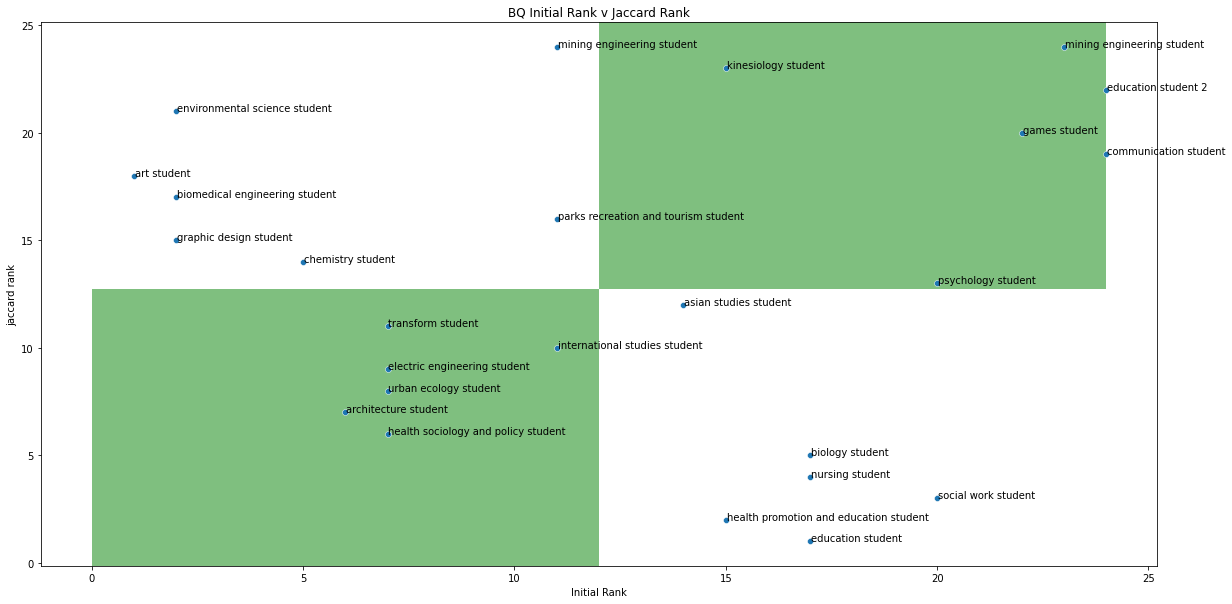

In [48]:
#create a quad plot so visualize the similarities between model ranks and BQ panel ranks
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(20, 10))
#plt.axhline(y=25) 
#plt.axvline(x=25) 
plt.axvspan(xmin = 0, xmax = 12, ymin=0, ymax = 0.51, facecolor='g', alpha=0.5)
plt.axvspan(xmin = 12, xmax = 24, ymin=0.51, ymax = 1, facecolor='g', alpha=0.5)

sp_jaccard_bq = sns.scatterplot(x=jaccard_bq['Initial Rank'], y=jaccard_bq['jaccard rank']).set_title('BQ Initial Rank v Jaccard Rank')

#label datapoints
def label_point(x, y, val, ax):
    a = pandas.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))
        
label_point(jaccard_bq['Initial Rank'], jaccard_bq['jaccard rank'], jaccard_bq.name, plt.gca()) 

        
sp_jaccard_bq

In [49]:
#model evaluations
#calculating via pandas function .corr
#Kendall tau-b reports value between -1 to 1. Closer to 0 means weaker association. B variation handles tied values better.
jaccard_kendall = jaccard_bq['Initial Rank'].corr(jaccard_bq['jaccard rank'], method = 'kendall')
jaccard_kendall 

-0.0309943377369126

In [50]:
#calculating Kendall's tau-b and p-value using scipy. 
#fun fact: all of this code was generated by ChatGPT
#drop rows that are nan due to pdf parse
jaccard_bq = jaccard_bq.dropna(subset=['jaccard rank'])

from scipy.stats import kendalltau
tau, kendall_p_value = kendalltau(jaccard_bq['jaccard rank'], jaccard_bq['Initial Rank'], variant ='b', nan_policy='omit')
                          
print("Kendall's tau-b:", tau)
print("p-value:", kendall_p_value)

Kendall's tau-b: -0.0309943377369126
p-value: 0.8324493839920712


In [51]:
#calculating spearman correlation coefficient using pandas. Alternative to Kendall tau-b. 
jaccard_spearman = jaccard_bq['Initial Rank'].corr(jaccard_bq['jaccard rank'], method = 'spearman')
jaccard_spearman

0.023579689316130047

In [52]:
from scipy import stats
spearman, spearman_p_value = stats.spearmanr(jaccard_bq['jaccard rank'], jaccard_bq['Initial Rank'], nan_policy = 'omit')
                          
print(spearman)
print(spearman_p_value)

0.023579689316130047
0.9109203858959855


In [53]:
#calculating pearson correlation coefficient using pandas. Alternative to Kendall tau-b and spearman. 
jaccard_pearson = jaccard_bq['Initial Rank'].corr(jaccard_bq['jaccard rank'], method = 'pearson')
jaccard_pearson

0.04147919566339915

In [54]:
pearson, pearson_p_value = stats.pearsonr(jaccard_bq['jaccard rank'], jaccard_bq['Initial Rank']) #, nan_policy = 'omit')

print(pearson)
print(pearson_p_value)

0.04147919566339918
0.843935221908043


In [55]:
#putting results from scipy stats in a dataframe. 
data = [["name", "kendall", "kendall p-value", "spearman", "spearman p-value", "pearson",'pearson p-value'], [
    ['jaccard processed', tau, kendall_p_value, spearman, spearman_p_value, pearson, pearson_p_value]]]
model_eval_results_df = pandas.DataFrame(data=data[1], columns=data[0])
model_eval_results_df 

,name,kendall,kendall p-value,spearman,spearman p-value,pearson,pearson p-value
0,jaccard processed,-0.030994,0.832449,0.02358,0.91092,0.041479,0.843935


### TF-IDF and Cosine Similarity
#### TF-IDF

In [56]:
#Term Frequency-Inverse Document Frequency (TF-IDF) and cosine similarity - 
# For Jaccard similarity / euclidean distance, a larger body of text, which has more words in terms of variety 
#and frequency, will have a much greater magnitude than a smaller body text even if they share the same topic.
#TF-IDF uses cosine similarity - the angle between two vectors - which addresses this issue. The cosine similarity considers the angle 
#between two vectors without examining the magnitude of the vectors.
#https://towardsdatascience.com/comparing-documents-with-similarity-metrics-e486bc678a7d


#TF-IDF gets this importance score by getting the term’s frequency (TF) and multiplying it by the term 
#inverse document frequency (IDF). The higher the TF-IDF score the rarer the term in a document and
#the higher its importance.
#https://medium.com/analytics-vidhya/best-nlp-algorithms-to-get-document-similarity-a5559244b23b

#TF-IDF score ranks a word by its importance. 
#tf-idf(t) = tf(t,d) x idf(t)
#The TF-IDF score of a word, w, is tf(w)*idf(w)
#Where tf(w) = (Number of times the word appears in a document) / (Total numbers of words in the document)
# And where inverse document frequency, idf(w) = log(Number of documents / Number of documents that contain word w). 

#term frequency: number of times a word appears in a document
#document frequency: number of documents in the collection that contain a word
#log "dampens" the effect

#TF-IDF is the best known weighting scheme in information retrieval
# The score increases with the number of occurences within a document. 
#Also increases with the rarity of the term in the collection. 

In [57]:
#preparing dataframes for model. Adding pd to resume df. 

combo_parsed_pd = parsed_df.copy(deep = True)

#convert position description from list to df
position_description_lower_df = pandas.DataFrame([position_description_lower])
#add label for position description
position_description_lower_df.insert(0, "name", ["position description"], True)
#rename columns of the position description df
position_description_lower_df.columns = ["name", "value"]
#Concatanate position description dataframe to the resumes dataframe
combo_parsed_pd = pandas.concat([position_description_lower_df, combo_parsed_pd], ignore_index=True)
#drop empty rows
combo_parsed_pd['value'].replace('', np.nan, inplace=True)
combo_parsed_pd = combo_parsed_pd[combo_parsed_pd['value'].notna()]
combo_parsed_pd.reset_index(drop=True, inplace=True)

combo_parsed_pd



,name,value
0,position description,title classification salary range manager employment equity management team classified...
1,nursing student,nursing student salt lake city ut 555 5555 nursingstudent utah edu www linkedin com in ...
2,social work student,social work student salt lake city ut socialworkstudent2 domain com 555 555 5555 educati...
3,health society and policy student,health society and policy student salt lake city ut 555 555 5555 policystude...
4,communication student,communication student salt lake city ut 555 555 5555 studentemail gmai com education b...
5,asian studies student,asian studies student may 20xx salt lake city ut ...
6,gamestudent,gamestudent1 email com coolkid com linkedin com in coolkid education masters in entertainm...
7,biomedical engineering student,biomedical engineering student biomedstudent1 domain com 555 55 5555 education b s bio...
8,graphic design student,graphic design student salt lake city ut 801 555 5555 graphicdesign email com myportfo...
9,electrical engineering student,electrical engineering student salt lake city utah 555 555 5555 electricalengineeringstud...


In [58]:
#Calculating tfidf value for each word in both pd and all resumes. Result is a vector space model. It is a sparse matrix. 

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(combo_parsed_pd['value'])
tfidf_term_matrix = tfidf_matrix.todense()
df_tfidf_matrix = pandas.DataFrame(tfidf_term_matrix, 
                  columns=tfidf_vectorizer.get_feature_names_out()) 

# #pandas.options.display.max_rows = 50 #5
# pandas.options.display.max_columns = 100 #3000
df_tfidf_matrix


,000,10,100,108,10th,11,110,12,120,1200,...,xrpd,year,yearly,years,young,youth,youthclinc,ystre,zealand,zoo
0,0.000000,0.020573,0.000000,0.070974,0.00000,0.019058,0.000000,0.030688,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.012615,0.017731,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.144308,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.097227,0.022776,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.027690,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.023975,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.027427,0.048869,0.000000,0.040968,0.000000,0.055141,0.000000,0.000000,0.000000
4,0.000000,0.022452,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.051638,...,0.000000,0.025684,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.024974,0.035102,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.028569,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.052094,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.024530,0.043708,0.000000,0.000000,0.036641,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.055580,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.047486,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.059634,0.000000,0.000000,0.000000,...,0.000000,0.059324,0.000000,0.000000,0.044307,0.000000,0.000000,0.000000,0.000000,0.000000


### visualization of cosine similarity

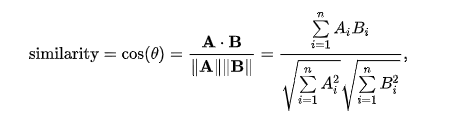
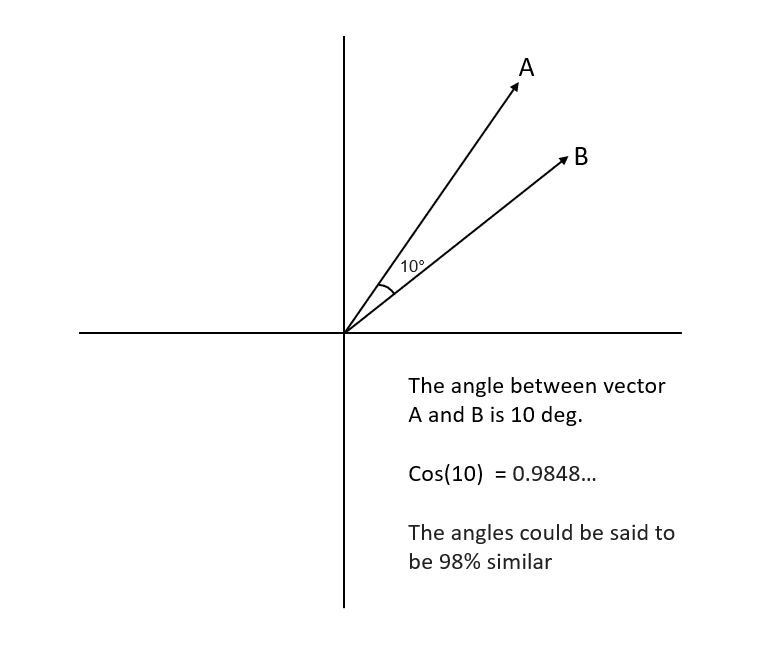

In [59]:
#checking the cosine similarity calculation by calculating score manually
#for cosine similarity, you do length normalization so long and short documents now have comparable weights
#cosine similarity = sum dot product between two vectors / length normalization of the vectors on the bottom
# can take apart : cosine similarity = taking each vector and length normalizing it and then taking the dot product of 
    # the vectors
#length normalization, to find length of the vector = sum of the squared value of each of it's components and then take the
    #squre root of this sum. 

#before calcuating cosine similarity between each resume and the pd in a code chunk below, I'm checking the math here. 
import numpy as np
from numpy.linalg import norm
position_description_vector = df_tfidf_matrix.iloc[0].tolist()
lasondra_vector = df_tfidf_matrix.iloc[1].tolist()
check_cos_sim_x_y = np.dot(position_description_vector, lasondra_vector)/(norm(position_description_vector)*norm(lasondra_vector))
check_cos_sim_x_y 

0.06449015658080481

In [60]:
#calculating cosine similarity for another resume as a check
position_description_vector = df_tfidf_matrix.iloc[0].tolist()
danielle_vector = df_tfidf_matrix.iloc[2].tolist()
check_cos_sim_x_y_danielle = np.dot(position_description_vector, danielle_vector)/(norm(position_description_vector)*norm(danielle_vector))
check_cos_sim_x_y_danielle

0.07799546231487248

In [61]:
# Actually calcuating cosing similarity between pd and each resume
#cosine similarity (CS) = (A . B) / (||A|| ||B||) = dotproduct of vectors / (sqrt of first vector *sqrt of second vector)

from sklearn.metrics.pairwise import cosine_similarity
dj=pandas.DataFrame(cosine_similarity(df_tfidf_matrix, dense_output=True))
dj 

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,1.000000,0.064490,0.077995,0.035615,0.049545,0.060711,0.024129,0.045778,0.030562,0.045985,...,0.053403,0.054671,0.046526,0.023606,0.048747,0.076718,0.030792,0.060245,0.028935,0.024035
1,0.064490,1.000000,0.201192,0.182314,0.167471,0.138074,0.030447,0.117217,0.105496,0.079677,...,0.153632,0.243496,0.230809,0.139388,0.211335,0.192153,0.135826,0.183837,0.144613,0.230561
2,0.077995,0.201192,1.000000,0.258250,0.154096,0.203385,0.042229,0.127225,0.155778,0.178991,...,0.168919,0.115707,0.205824,0.076725,0.126222,0.162858,0.157840,0.079210,0.108050,0.078474
3,0.035615,0.182314,0.258250,1.000000,0.207865,0.268160,0.059525,0.206305,0.198995,0.211199,...,0.189127,0.139142,0.181930,0.112652,0.165969,0.175425,0.155391,0.078050,0.117920,0.095369
4,0.049545,0.167471,0.154096,0.207865,1.000000,0.167010,0.067634,0.157083,0.241842,0.166543,...,0.135930,0.093701,0.192698,0.745522,0.197121,0.230768,0.130733,0.055870,0.213969,0.096825
5,0.060711,0.138074,0.203385,0.268160,0.167010,1.000000,0.026414,0.158575,0.153182,0.134389,...,0.120701,0.253105,0.158204,0.088853,0.134363,0.109674,0.129089,0.073553,0.105187,0.083817
6,0.024129,0.030447,0.042229,0.059525,0.067634,0.026414,1.000000,0.063504,0.067964,0.083681,...,0.043442,0.035087,0.024964,0.069969,0.017811,0.037433,0.018600,0.017253,0.021732,0.014218
7,0.045778,0.117217,0.127225,0.206305,0.157083,0.158575,0.063504,1.000000,0.115968,0.198932,...,0.107877,0.067106,0.126589,0.117987,0.131724,0.067582,0.096032,0.056972,0.088514,0.039922
8,0.030562,0.105496,0.155778,0.198995,0.241842,0.153182,0.067964,0.115968,1.000000,0.144781,...,0.169253,0.080176,0.135756,0.131795,0.117567,0.158362,0.128120,0.063001,0.141218,0.135664
9,0.045985,0.079677,0.178991,0.211199,0.166543,0.134389,0.083681,0.198932,0.144781,1.000000,...,0.094027,0.119650,0.167319,0.140691,0.080792,0.120797,0.069868,0.061495,0.099482,0.072367


In [62]:
#convert cosine similarity matrix to results

#join cosine results to original dataframe
join_data_cosine = pandas.concat([combo_parsed_pd, dj], axis=1, ignore_index=True)
#drop column with text
join_data_cosine.drop(join_data_cosine.columns[1], axis=1, inplace = True)
#make first column of names a list
column_headers = join_data_cosine[0].tolist()
#add a "name" placeholder for first column
column_headers.insert(0, 'name')
#make list of names column headers 
join_data_cosine.columns = column_headers
#only keep first row data, which is the similarity scores for the position description
position_description_cosine = join_data_cosine.head(1)
#transpose so columns are rows
position_description_cosine = position_description_cosine.T
#reset index
position_description_cosine = position_description_cosine.reset_index(drop = False)
#rename columns
position_description_cosine.columns = ["name", "cosine sim"]
#drop the first row, which are just additional labels 
position_description_cosine = position_description_cosine.drop(0)
#Convert cosine similarity score to numeric
position_description_cosine["cosine sim"] = pandas.to_numeric(position_description_cosine["cosine sim"])
#Sort cosine similarity values from large
position_description_cosine = position_description_cosine.sort_values(by=['cosine sim'], ascending=False)
#adding number of words
parsed_df_word_count = parsed_df_lem_sim[['name','no. words']]
position_description_cosine = pandas.merge(position_description_cosine, parsed_df_word_count, on=['name'])

position_description_cosine#.dtypes
#join_data_cosine

,name,cosine sim,no. words
0,social work student,0.077995,607
1,education student,0.076914,312
2,biology student,0.076718,265
3,architechture student,0.071567,394
4,nursing student,0.064490,663
5,asian studies student,0.060711,287
6,parks recreation and tourism uni,0.060245,239
7,education student 2,0.054671,269
8,health promotion and education student,0.053403,243
9,communication student,0.049545,421


In [63]:
#william m tho reported a large number of words. This is because it is an incorrect parse. The code parsed on an 
#authorization act. This name should be removed. 

#parsed['william m   tho']#[-3000:-1]

In [64]:
#report and sort by words with the highest tfidf score
pandas.set_option('display.max_rows', 5000)
position_description_words = df_tfidf_matrix.copy(deep = True)
position_description_words = position_description_words.head(1)
position_description_words = position_description_words.loc[:, (position_description_words != 0).any(axis=0)]
position_description_words = position_description_words.T
#reset index
position_description_words = position_description_words.reset_index(drop = False)
#rename columns
position_description_words.columns = ["word", "tfidf"]
position_description_words = position_description_words.sort_values(by=['tfidf'], ascending=False)
position_description_words.head(20)

,word,tfidf
119,employment,0.377408
262,recruitment,0.272573
151,human,0.260237
123,equity,0.212921
133,faculty,0.209671
294,serves,0.189263
301,staff,0.168704
124,equivalency,0.165605
277,resources,0.159039
60,classified,0.141947


In [65]:
#define a function that compares list of names generated by the model to the bq panel scores
def model_evaluations(model_output):

    global merged_fuzz_cosine, model_bq, plot_model_bq, tau, kendall_p_value, spearman, spearman_p_value, pearson, pearson_p_value

    #join cosine output with orignal names before fuzzy matching
    model_output = model_output[model_output['name'] != "william m   tho"]#incorrect parse
    model_output = model_output[model_output['name'] != "position description"] #remove pd if exists in model ranks
    model_output['model rank'] = model_output['cosine sim'].rank(ascending = False)
    model_output = model_output[["name", "model rank"]]
    
    #remove leading space that was resulting in no merge 
    fuzz_match_names['name'] = fuzz_match_names['name'].str.lstrip()
    fuzz_match_names['name'] = fuzz_match_names['name'].str.rstrip()
    model_output['name'] = model_output['name'].str.lstrip()
    model_output['name'] = model_output['name'].str.rstrip()
    merged_fuzz_cosine = pandas.merge(model_output, fuzz_match_names, on = 'name')
    merged_fuzz_cosine = merged_fuzz_cosine.drop(['name'], axis=1)
    merged_fuzz_cosine = merged_fuzz_cosine.rename(columns={'original': 'name'})

    #merge cosine results with bq panel rank
    merged_fuzz_cosine['name'] = merged_fuzz_cosine['name'].apply(lambda x: difflib.get_close_matches(x, ea_df_strip['name'])[0])
    model_bq = pandas.merge(merged_fuzz_cosine, ea_df_strip, on = 'name', how = 'inner') #merge jaccard with bq panel rankings
    model_bq = model_bq[model_bq['model rank'].notna()] #drop any rows where the model rank is blank
    model_bq = model_bq.sort_values(by=['Initial Rank'], ascending = True)
    model_bq = model_bq.reset_index(drop=True)

    #plot the model/bq results
    fig, ax = plt.subplots(figsize=(20, 10))
   # plt.axhline(y=25) 
   # plt.axvline(x=25) 
    plt.axvspan(xmin = 0, xmax = 12, ymin=0, ymax = 0.5, facecolor='g', alpha=0.5)
    plt.axvspan(xmin = 12, xmax = 24, ymin=0.5, ymax = 1, facecolor='g', alpha=0.5)
    plot_model_bq = sns.scatterplot(x=model_bq['Initial Rank'], y=model_bq['model rank']).set_title('BQ Initial Rank v Model Rank')
    label_point(model_bq['Initial Rank'], model_bq['model rank'], model_bq.name, plt.gca()) 

    #calculate ranking coeficients. -1 to 1. Closer to 0 means weaker association
    model_bq = model_bq.dropna(subset=['model rank'])
    tau, kendall_p_value = kendalltau(model_bq['Initial Rank'], model_bq['model rank'], variant ='b')
    spearman, spearman_p_value = stats.spearmanr(model_bq['Initial Rank'], model_bq['model rank'])
    pearson, pearson_p_value = stats.pearsonr(model_bq['Initial Rank'], model_bq['model rank'])

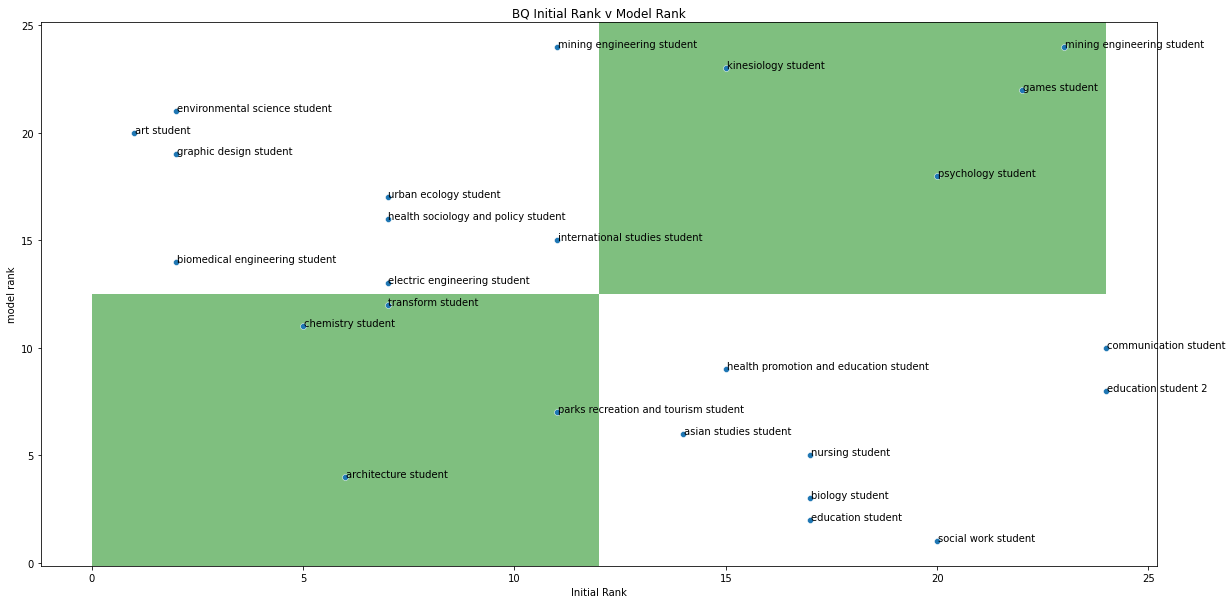

In [66]:
model_evaluations(position_description_cosine)

In [67]:
#checking function results
#merged_fuzz_cosine

In [68]:
#renaming model results to use later
eval_all_cosine_no_process = model_bq
eval_all_cosine_no_process 

,model rank,name,Initial Rank
0,20.0,art student,1
1,21.0,environmental science student,2
2,14.0,biomedical engineering student,2
3,19.0,graphic design student,2
4,11.0,chemistry student,5
5,4.0,architecture student,6
6,12.0,transform student,7
7,16.0,health sociology and policy student,7
8,17.0,urban ecology student,7
9,13.0,electric engineering student,7


In [69]:
#adding correlation coefficients to df containing jaccard results
def append_row(df, row):
    return pandas.concat([
                df, 
                pandas.DataFrame([row], columns=row.index)]
           ).reset_index(drop=True)

new_row = pandas.Series({'name': 'cosine no process all words', 
                         'kendall': tau, 
                         "kendall p-value" : kendall_p_value,
                         'spearman': spearman, 
                         "spearman p-value": spearman_p_value,
                         'pearson':pearson,
                         'pearson p-value': pearson_p_value })

model_eval_results_df = append_row(model_eval_results_df, new_row)
model_eval_results_df

,name,kendall,kendall p-value,spearman,spearman p-value,pearson,pearson p-value
0,jaccard processed,-0.030994,0.832449,0.023580,0.910920,0.041479,0.843935
1,cosine no process all words,-0.182522,0.212816,-0.212604,0.307576,-0.212226,0.308458


### Cosine similarity (cont).
#### Count Vectors

In [70]:
#Count vectorizer code. Instead of giving each word a frequency weighting via TFIDF, this counts the number of times
#a word appears in a document

from sklearn.feature_extraction.text import CountVectorizer

#Create the Document Term Matrix
count_vectorizer = CountVectorizer(stop_words='english')
count_sparse_matrix = count_vectorizer.fit_transform(combo_parsed_pd['value'])

#Convert Sparse Matrix to df
count_doc_term_matrix = count_sparse_matrix.todense()
count_df_matrix = pandas.DataFrame(count_doc_term_matrix, 
                  columns=count_vectorizer.get_feature_names_out()) 

count_df_matrix #.head(9)


,000,10,100,108,10th,11,110,12,120,1200,...,xrpd,year,yearly,years,young,youth,youthclinc,ystre,zealand,zoo
0,0,2,0,3,0,1,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,1,0,0,0,0,0,0,0,...,0,10,0,0,0,0,0,0,0,0
2,0,6,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,0
4,0,1,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
5,0,1,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,1,0,0,0,0
8,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
9,0,0,0,0,0,0,1,0,0,0,...,0,2,0,0,1,0,0,0,0,0


In [71]:
#Calculating cosine similarity as before:
#cosine similarity (CS) = (A . B) / (||A|| ||B||) = dotproduct of vectors / (sqrt of first vector *sqrt of second vector)

#from sklearn.metrics.pairwise import cosine_similarity
count_dj=pandas.DataFrame(cosine_similarity(count_df_matrix, dense_output=True))
count_dj #.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,1.000000,0.095614,0.114202,0.057141,0.074110,0.089962,0.052094,0.069381,0.049150,0.077970,...,0.083627,0.074416,0.080309,0.044964,0.082270,0.110372,0.046445,0.115803,0.070897,0.041299
1,0.095614,1.000000,0.346143,0.398385,0.409570,0.335839,0.075156,0.227376,0.333971,0.208056,...,0.320431,0.412445,0.415287,0.299192,0.463670,0.426349,0.314452,0.342211,0.372135,0.431076
2,0.114202,0.346143,1.000000,0.473988,0.353568,0.401318,0.092042,0.281451,0.359179,0.337326,...,0.330145,0.240660,0.368314,0.200077,0.321109,0.352784,0.352693,0.176932,0.301120,0.205980
3,0.057141,0.398385,0.473988,1.000000,0.515806,0.510506,0.124747,0.410639,0.512365,0.393056,...,0.418490,0.304137,0.362262,0.281198,0.447889,0.430705,0.416070,0.199998,0.390057,0.291847
4,0.074110,0.409570,0.353568,0.515806,1.000000,0.424997,0.137037,0.325414,0.544989,0.336067,...,0.388770,0.255808,0.366140,0.768410,0.501857,0.497596,0.388747,0.172928,0.508794,0.309016
5,0.089962,0.335839,0.401318,0.510506,0.424997,1.000000,0.076989,0.318885,0.410442,0.302184,...,0.310630,0.369820,0.337808,0.228359,0.378953,0.324459,0.335525,0.157048,0.342547,0.234032
6,0.052094,0.075156,0.092042,0.124747,0.137037,0.076989,1.000000,0.152683,0.145173,0.190382,...,0.101547,0.073063,0.067973,0.144203,0.062190,0.089305,0.057036,0.069691,0.079163,0.053078
7,0.069381,0.227376,0.281451,0.410639,0.325414,0.318885,0.152683,1.000000,0.266437,0.374218,...,0.207211,0.204925,0.272887,0.226437,0.263835,0.175488,0.198478,0.155726,0.233615,0.132147
8,0.049150,0.333971,0.359179,0.512365,0.544989,0.410442,0.145173,0.266437,1.000000,0.300086,...,0.413500,0.220226,0.254644,0.310968,0.404036,0.431146,0.384232,0.175402,0.428705,0.347859
9,0.077970,0.208056,0.337326,0.393056,0.336067,0.302184,0.190382,0.374218,0.300086,1.000000,...,0.211932,0.264248,0.329879,0.267921,0.224890,0.240706,0.209336,0.141505,0.249137,0.186958


In [72]:
#convert cosine similarity matrix to results

#join cosine results to original dataframe
count_join_data_cosine = pandas.concat([combo_parsed_pd, count_dj], axis=1, ignore_index=True)
#drop column with resumes
count_join_data_cosine.drop(count_join_data_cosine.columns[1], axis=1, inplace = True)
#make first column of names a list
count_column_headers = count_join_data_cosine[0].tolist()
#add a "name" placeholder for first column
count_column_headers.insert(0, 'name')
#make list of names column headers 
count_join_data_cosine.columns = count_column_headers
#only keep first row data, which is the similarity scores for the position description
count_position_description_cosine = count_join_data_cosine.head(1)
#transpose so columns are rows
count_position_description_cosine = count_position_description_cosine.T
#reset index
count_position_description_cosine = count_position_description_cosine.reset_index(drop = False)
#rename columns
count_position_description_cosine.columns = ["name", "cosine sim"]
#drop the first row, which are just additional labels 
count_position_description_cosine = count_position_description_cosine.drop(0)
#Convert cosine similarity score to numeric
count_position_description_cosine["cosine sim"] = pandas.to_numeric(count_position_description_cosine ["cosine sim"])
#Sort cosine similarity values from large
count_position_description_cosine  = count_position_description_cosine .sort_values(by=['cosine sim'], ascending=False)
count_position_description_cosine.reset_index(drop=True, inplace=True)

count_position_description_cosine#.dtypes


,name,cosine sim
0,position description,1.000000
1,education student,0.119227
2,parks recreation and tourism uni,0.115803
3,social work student,0.114202
4,biology student,0.110372
5,architechture student,0.109171
6,nursing student,0.095614
7,asian studies student,0.089962
8,health promotion and education student,0.083627
9,chemistry student,0.082270


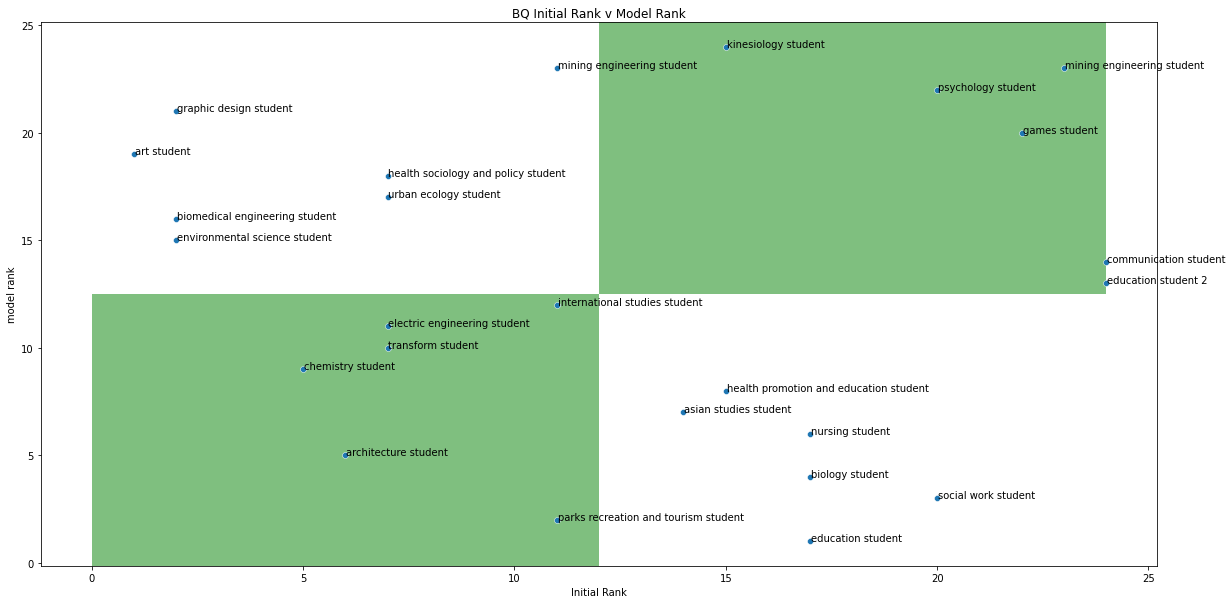

In [73]:
model_evaluations(count_position_description_cosine)

In [74]:
#merged_fuzz_cosine

In [75]:
eval_all_cosine_count = model_bq
eval_all_cosine_count

,model rank,name,Initial Rank
0,19.0,art student,1
1,21.0,graphic design student,2
2,15.0,environmental science student,2
3,16.0,biomedical engineering student,2
4,9.0,chemistry student,5
5,5.0,architecture student,6
6,10.0,transform student,7
7,11.0,electric engineering student,7
8,18.0,health sociology and policy student,7
9,17.0,urban ecology student,7


In [76]:
new_row = pandas.Series({'name': 'cosine no process all words count', 
                         'kendall': tau, 
                         "kendall p-value" : kendall_p_value,
                         'spearman': spearman, 
                         "spearman p-value": spearman_p_value,
                         'pearson':pearson,
                         'pearson p-value': pearson_p_value })

model_eval_results_df = append_row(model_eval_results_df, new_row)
model_eval_results_df

,name,kendall,kendall p-value,spearman,spearman p-value,pearson,pearson p-value
0,jaccard processed,-0.030994,0.832449,0.023580,0.910920,0.041479,0.843935
1,cosine no process all words,-0.182522,0.212816,-0.212604,0.307576,-0.212226,0.308458
2,cosine no process all words count,-0.079208,0.588744,-0.067260,0.749389,-0.067379,0.748961


## Cosine Similarity (cont.)
### TFIDF - stopwords removed via nltk

In [77]:
#preparing the dataframe
from nltk.tokenize.treebank import TreebankWordDetokenizer
combo_parsed_pd_no_stop = parsed_df_no_stop.copy(deep = True)
#reverse tokenize parsed df
combo_parsed_pd_no_stop["value"] = combo_parsed_pd_no_stop.apply(lambda row: TreebankWordDetokenizer().detokenize((row['value'])), axis=1)
#convert position description from list to df
position_description_no_stop_no_token = TreebankWordDetokenizer().detokenize(position_description_no_stop)
#reverse tokenize pd
position_description_no_stop_df = pandas.DataFrame([position_description_no_stop_no_token])
#add label for position description
position_description_no_stop_df.insert(0, "name", ["position description"], True)
#rename columns of the position description df
position_description_no_stop_df.columns = ["name", "value"]
#Concatanate position description dataframe to the resumes dataframe
combo_parsed_pd_no_stop = pandas.concat([position_description_no_stop_df, combo_parsed_pd_no_stop], ignore_index=True)

combo_parsed_pd_no_stop


,name,value
0,position description,title classification salary range manager employment equity management team classified superviso...
1,nursing student,nursing student salt lake city ut 555 5555 nursingstudent utah edu www linkedin com nursingstamp...
2,social work student,social work student salt lake city ut socialworkstudent2 domain com 555 555 5555 education bache...
3,health society and policy student,health society policy student salt lake city ut 555 555 5555 policystudent1 email com education ...
4,communication student,communication student salt lake city ut 555 555 5555 studentemail gmai com education bachelor sc...
5,asian studies student,asian studies student may 20xx salt lake city ut emphasis japanese language history cultural awa...
6,gamestudent,gamestudent1 email com coolkid com linkedin com coolkid education masters entertainment arts eng...
7,biomedical engineering student,biomedical engineering student biomedstudent1 domain com 555 55 5555 education b biomedical engi...
8,graphic design student,graphic design student salt lake city ut 801 555 5555 graphicdesign email com myportfolio com ed...
9,electrical engineering student,electrical engineering student salt lake city utah 555 555 5555 electricalengineeringstudent1 do...


In [78]:
#calculating TFIDF on dataframe with stopwords removed via nltk
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix_no_stop = tfidf_vectorizer.fit_transform(combo_parsed_pd_no_stop['value'])

tfidf_matrix_no_stop = tfidf_matrix_no_stop.todense()
df_tfidf_matrix_no_stop = pandas.DataFrame(tfidf_matrix_no_stop, 
                  columns=tfidf_vectorizer.get_feature_names_out()) 

#pandas.options.display.max_rows = 50 #5
pandas.options.display.max_columns = 100 #3000
df_tfidf_matrix_no_stop


,000,10,100,108,10th,11,110,12,120,1200,123,12th,13,13th,14,15,16,17,18,19,1st,20,200,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,20s,20xx,21,22,225,23,24,25,26,27,28,29,2d,2nd,30,300,...,weekly,weeks,weight,welcoming,welfare,wellbeing,wellness,west,western,wet,wide,wilderness,williams,window,winona,wireless,withdrawn,women,wood,word,work,worked,worker,workers,workforce,working,workout,workouts,works,workshop,workshops,workup,world,wound,wrapper,writers,writing,written,wrote,www,xrpd,year,yearly,years,young,youth,youthclinc,ystre,zealand,zoo
0,0.000000,0.020573,0.000000,0.070974,0.00000,0.019058,0.000000,0.030688,0.000000,0.000000,0.000000,0.000000,0.017577,0.000000,0.019058,0.015344,0.019058,0.019058,0.016367,0.019058,0.000000,0.013676,0.000000,0.000000,0.020967,0.000000,0.000000,0.000000,0.012345,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019058,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019058,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.023658,0.052731,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.052731,0.019058,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.012615,0.017731,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.023372,0.000000,0.050316,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.286462,0.023372,0.023372,0.029013,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.023372,...,0.000000,0.000000,0.029013,0.000000,0.000000,0.029013,0.000000,0.021556,0.000000,0.000000,0.046743,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.029013,0.000000,0.00000,0.000000,0.000000,0.000000,0.023372,0.000000,0.144308,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.097295,0.022792,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033053,0.000000,0.099159,0.048378,0.061373,0.043119,0.116763,0.077703,0.000000,0.000000,0.024189,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030043,0.033053,0.000000,0.037295,0.037295,0.000000,0.000000,0.000000,0.000000,...,0.040915,0.030043,0.000000,0.000000,0.000000,0.000000,0.000000,0.055418,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.051603,0.000000,0.000000,0.051603,0.000000,0.066106,0.090130,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030043,0.000000,0.033053,0.000000,0.000000,0.00000,0.000000,0.030043,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.027709,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.023975,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.031877,0.000000,0.000000,0.000000,0.000000,0.000000,0.031877,0.000000,0.137863,0.115091,0.000000,0.035764,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.048869,0.044420,0.048869,0.055141,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.060494,0.044420,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.038148,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00

In [79]:
# Actually doing the cosine similarity comparisons now:
#cosine similarity (CS) = (A . B) / (||A|| ||B||) = dotproduct of vectors / (sqrt of first vector *sqrt of second vector)

from sklearn.metrics.pairwise import cosine_similarity
dj_no_stop = pandas.DataFrame(cosine_similarity(df_tfidf_matrix_no_stop, dense_output=True))
dj_no_stop #.head()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,1.000000,0.064490,0.078050,0.035615,0.049545,0.060711,0.024129,0.045778,0.030562,0.045985,0.043918,0.071567,0.035600,0.030283,0.076914,0.053403,0.054671,0.046526,0.023606,0.048747,0.076718,0.030792,0.060245,0.028935,0.024035
1,0.064490,1.000000,0.201332,0.182314,0.167471,0.138074,0.030447,0.117217,0.105496,0.079677,0.202943,0.185084,0.112547,0.064482,0.152196,0.153632,0.243496,0.230809,0.139388,0.211335,0.192153,0.135826,0.183837,0.144613,0.230561
2,0.078050,0.201332,1.000000,0.258430,0.154203,0.203527,0.042258,0.127313,0.155887,0.179115,0.191559,0.104995,0.180643,0.118684,0.181768,0.169037,0.115787,0.205967,0.076779,0.126310,0.162971,0.157950,0.079265,0.108125,0.078529
3,0.035615,0.182314,0.258430,1.000000,0.207865,0.268160,0.059525,0.206305,0.198995,0.211199,0.170467,0.081034,0.234671,0.130703,0.191644,0.189127,0.139142,0.181930,0.112652,0.165969,0.175425,0.155391,0.078050,0.117920,0.095369
4,0.049545,0.167471,0.154203,0.207865,1.000000,0.167010,0.067634,0.157083,0.241842,0.166543,0.158917,0.187717,0.187304,0.136342,0.167873,0.135930,0.093701,0.192698,0.745522,0.197121,0.230768,0.130733,0.055870,0.213969,0.096825
5,0.060711,0.138074,0.203527,0.268160,0.167010,1.000000,0.026414,0.158575,0.153182,0.134389,0.247600,0.061334,0.170093,0.140277,0.217629,0.120701,0.253105,0.158204,0.088853,0.134363,0.109674,0.129089,0.073553,0.105187,0.083817
6,0.024129,0.030447,0.042258,0.059525,0.067634,0.026414,1.000000,0.063504,0.067964,0.083681,0.029098,0.052163,0.054262,0.038460,0.032652,0.043442,0.035087,0.024964,0.069969,0.017811,0.037433,0.018600,0.017253,0.021732,0.014218
7,0.045778,0.117217,0.127313,0.206305,0.157083,0.158575,0.063504,1.000000,0.115968,0.198932,0.155333,0.098507,0.201383,0.088691,0.154981,0.107877,0.067106,0.126589,0.117987,0.131724,0.067582,0.096032,0.056972,0.088514,0.039922
8,0.030562,0.105496,0.155887,0.198995,0.241842,0.153182,0.067964,0.115968,1.000000,0.144781,0.117111,0.160834,0.240058,0.200315,0.149544,0.169253,0.080176,0.135756,0.131795,0.117567,0.158362,0.128120,0.063001,0.141218,0.135664
9,0.045985,0.079677,0.179115,0.211199,0.166543,0.134389,0.083681,0.198932,0.144781,1.000000,0.101165,0.101714,0.198104,0.111005,0.120150,0.094027,0.119650,0.167319,0.140691,0.080792,0.120797,0.069868,0.061495,0.099482,0.072367


In [80]:
#convert cosine similarity matrix to results

#join cosine results to original dataframe
join_data_cosine_no_stop = pandas.concat([combo_parsed_pd_no_stop, dj_no_stop], axis=1, ignore_index=True)
#drop column with text
join_data_cosine_no_stop.drop(join_data_cosine_no_stop.columns[1], axis=1, inplace = True)
#make first column of names a list
column_headers_no_stop = join_data_cosine_no_stop[0].tolist()
#add a "name" placeholder for first column
column_headers_no_stop.insert(0, 'name')
#make list of names column headers 
join_data_cosine_no_stop.columns = column_headers_no_stop
#only keep first row data, which is the similarity scores for the position description
position_description_cosine_no_stop = join_data_cosine_no_stop.head(1)
#transpose so columns are rows
position_description_cosine_no_stop = position_description_cosine_no_stop.T
#reset index
position_description_cosine_no_stop = position_description_cosine_no_stop.reset_index(drop = False)
#rename columns
position_description_cosine_no_stop.columns = ["name", "cosine sim"]
#drop the first row, which are just additional labels 
position_description_cosine_no_stop = position_description_cosine_no_stop.drop(0)
#Convert cosine similarity score to numeric
position_description_cosine_no_stop["cosine sim"] = pandas.to_numeric(position_description_cosine_no_stop["cosine sim"])
#Sort cosine similarity values from large
position_description_cosine_no_stop = position_description_cosine_no_stop.sort_values(by=['cosine sim'], ascending=False)
position_description_cosine_no_stop.reset_index(drop=True, inplace=True)

position_description_cosine_no_stop#.dtypes


,name,cosine sim
0,position description,1.000000
1,social work student,0.078050
2,education student,0.076914
3,biology student,0.076718
4,architechture student,0.071567
5,nursing student,0.064490
6,asian studies student,0.060711
7,parks recreation and tourism uni,0.060245
8,education student 2,0.054671
9,health promotion and education student,0.053403


In [81]:
#Display words and tfidf weights for position description

pandas.set_option('display.max_rows', 5000)

position_description_words_no_stop = df_tfidf_matrix_no_stop.copy(deep = True)
position_description_words_no_stop  = position_description_words_no_stop.head(1)
position_description_words_no_stop = position_description_words_no_stop.loc[:, (position_description_words_no_stop != 0).any(axis=0)]
position_description_words_no_stop = position_description_words_no_stop.T
#reset index
position_description_words_no_stop = position_description_words_no_stop.reset_index(drop = False)
#rename columns
position_description_words_no_stop.columns = ["word", "tfidf"]
position_description_words_no_stop = position_description_words_no_stop.sort_values(by=['tfidf'], ascending=False)

position_description_words_no_stop.head(15)

,word,tfidf
119,employment,0.377408
262,recruitment,0.272573
151,human,0.260237
123,equity,0.212921
133,faculty,0.209671
294,serves,0.189263
301,staff,0.168704
124,equivalency,0.165605
277,resources,0.159039
60,classified,0.141947


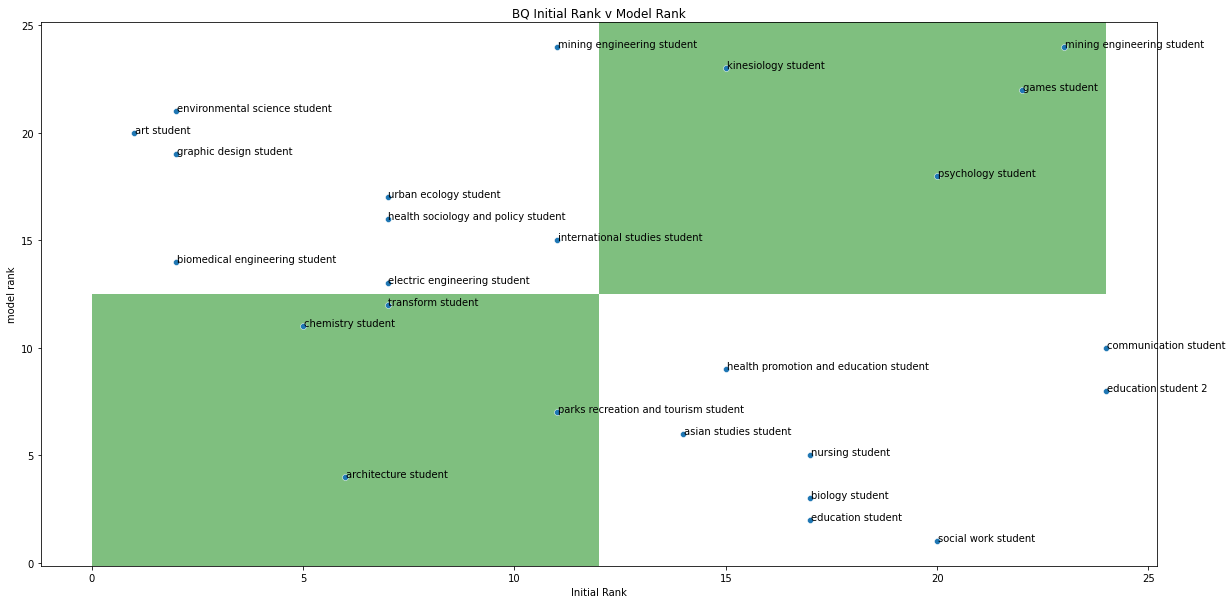

In [82]:
#evaluate model
model_evaluations(position_description_cosine_no_stop)

In [83]:
#merged_fuzz_cosine

In [84]:
eval_cosine_nltk_all = model_bq
eval_cosine_nltk_all

,model rank,name,Initial Rank
0,20.0,art student,1
1,21.0,environmental science student,2
2,14.0,biomedical engineering student,2
3,19.0,graphic design student,2
4,11.0,chemistry student,5
5,4.0,architecture student,6
6,12.0,transform student,7
7,16.0,health sociology and policy student,7
8,17.0,urban ecology student,7
9,13.0,electric engineering student,7


In [85]:
#adding results to the results dataframe collecting results for all the model evaluations
new_row = pandas.Series({'name': 'cosine no process all words nltk stop words', 
                         'kendall': tau, 
                         "kendall p-value" : kendall_p_value,
                         'spearman': spearman, 
                         "spearman p-value": spearman_p_value,
                         'pearson':pearson,
                         'pearson p-value': pearson_p_value })

model_eval_results_df = append_row(model_eval_results_df, new_row)
model_eval_results_df

,name,kendall,kendall p-value,spearman,spearman p-value,pearson,pearson p-value
0,jaccard processed,-0.030994,0.832449,0.023580,0.910920,0.041479,0.843935
1,cosine no process all words,-0.182522,0.212816,-0.212604,0.307576,-0.212226,0.308458
2,cosine no process all words count,-0.079208,0.588744,-0.067260,0.749389,-0.067379,0.748961
3,cosine no process all words nltk stop words,-0.182522,0.212816,-0.212604,0.307576,-0.212226,0.308458


## Cosine Similiarity (cont.)
### TFIDF with pd as query

In [86]:
#calculating TFIDF using only the pd words
#transform data in a document term matrix. Documents are rows, terms/features/words/tokens are columns.
#tfidf_vectorizer.fit(train) learns the vocabulary of the training data. 
#tfidf_vectorizer.transform(train) uses the fitted vocabulary to build a document-term matrix
    #from the training data. 
#can combine .fit and .transform into one step, .fit_transform
#tfidf_vectorizer.transform(test) uses fitted vocab to build a document term matrix
    #the testing data and ignores tokens it hasn't seen before (like all the other words in the resume)

from sklearn.feature_extraction.text import TfidfVectorizer
#instantiate the model
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
#fit the model only using pd words
pd_query_tfidf_matrix = tfidf_vectorizer.fit_transform(position_description_no_stop_df['value'])
#map back to actual pd words
pd_query_tfidf_matrix  = pd_query_tfidf_matrix .todense()
pd_query_tfidf_matrix  = pandas.DataFrame(pd_query_tfidf_matrix, 
                  columns=tfidf_vectorizer.get_feature_names_out()) 
pd_query_tfidf_matrix


,10,108,11,12,13,14,15,16,17,18,19,20,2012,2016,21,abilities,ability,absence,academic,accuracy,accurate,activities,ad,additional,administration,adverse,advertisements,advertising,advisory,affecting,ambiguous,analyzes,announcements,applicant,applicants,application,applications,apply,appropriate,approved,approves,area,assessment,assigned,assignments,assists,associate,bachelor,backup,basis,...,screening,section,selection,senate,sensitivity,serves,sessions,sheets,skills,software,sources,specific,staff,standard,state,streamline,student,students,submission,suggestions,supervise,supervises,supervision,supervisory,surveys,systems,tasks,team,techniques,tests,time,timelines,title,topics,train,training,trainings,trains,union,update,vacancy,various,verify,vice,website,wide,workforce,working,writing,written
0,0.039536,0.059304,0.019768,0.039536,0.019768,0.019768,0.019768,0.019768,0.019768,0.019768,0.019768,0.019768,0.019768,0.019768,0.019768,0.019768,0.019768,0.019768,0.019768,0.039536,0.019768,0.079072,0.019768,0.019768,0.019768,0.019768,0.039536,0.039536,0.019768,0.019768,0.019768,0.039536,0.039536,0.059304,0.059304,0.039536,0.019768,0.019768,0.019768,0.039536,0.019768,0.039536,0.039536,0.039536,0.019768,0.039536,0.019768,0.019768,0.019768,0.039536,...,0.039536,0.019768,0.09884,0.019768,0.019768,0.158145,0.019768,0.019768,0.019768,0.019768,0.039536,0.039536,0.256985,0.019768,0.019768,0.019768,0.019768,0.019768,0.019768,0.019768,0.039536,0.019768,0.059304,0.019768,0.019768,0.019768,0.019768,0.019768,0.039536,0.019768,0.039536,0.039536,0.019768,0.019768,0.019768,0.059304,0.059304,0.019768,0.019768,0.039536,0.019768,0.019768,0.019768,0.019768,0.059304,0.019768,0.019768,0.059304,0.059304,0.019768


In [87]:
#run fitted model on the resume
from nltk.tokenize.treebank import TreebankWordDetokenizer

parsed_df_no_stop_test = parsed_df_no_stop.copy(deep = True)
#de-tokenize parsed df
parsed_df_no_stop_test["value"] = parsed_df_no_stop_test.apply(lambda row: TreebankWordDetokenizer().detokenize((row['value'])), axis=1)

from sklearn.feature_extraction.text import TfidfVectorizer
parsed_df_no_stop_test_matrix = tfidf_vectorizer.transform(parsed_df_no_stop_test['value'])
parsed_df_no_stop_test_matrix  = parsed_df_no_stop_test_matrix.todense()
parsed_df_no_stop_test_matrix = pandas.DataFrame(parsed_df_no_stop_test_matrix, 
                  columns=tfidf_vectorizer.get_feature_names_out()) 

#pandas.options.display.max_rows = 50 #5
#pandas.options.display.max_columns = 2000 #3000
parsed_df_no_stop_test_matrix

,10,108,11,12,13,14,15,16,17,18,19,20,2012,2016,21,abilities,ability,absence,academic,accuracy,accurate,activities,ad,additional,administration,adverse,advertisements,advertising,advisory,affecting,ambiguous,analyzes,announcements,applicant,applicants,application,applications,apply,appropriate,approved,approves,area,assessment,assigned,assignments,assists,associate,bachelor,backup,basis,...,screening,section,selection,senate,sensitivity,serves,sessions,sheets,skills,software,sources,specific,staff,standard,state,streamline,student,students,submission,suggestions,supervise,supervises,supervision,supervisory,surveys,systems,tasks,team,techniques,tests,time,timelines,title,topics,train,training,trainings,trains,union,update,vacancy,various,verify,vice,website,wide,workforce,working,writing,written
0,0.060634,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.060634,0.181902,0.000000,0.000000,0.060634,0.000000,0.000000,0.0,0.060634,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.121268,0.0,0.0,0.000000,0.181902,0.0,0.060634,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.060634,0.0,0.000000,0.0,0.181902,0.000000,0.0,0.060634,0.181902,0.060634,0.121268,0.0,0.242536,0.363803,0.0,0.0,0.0,0.0,0.060634,0.0,0.000000,0.000000,0.000000,0.000000,0.060634,0.303170,0.000000,0.0,0.0,0.000000,0.060634,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.121268,0.0,0.000000,0.000000,0.000000
1,0.321634,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.160817,0.321634,0.000000,0.000000,0.000000,0.0,0.053606,0.000000,0.000000,0.107211,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.053606,0.000000,0.107211,0.000000,0.053606,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.053606,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.214423,0.000000,0.0,0.000000,0.053606,0.000000,0.000000,0.0,0.160817,0.375239,0.0,0.0,0.0,0.0,0.000000,0.0,0.053606,0.000000,0.000000,0.053606,0.000000,0.053606,0.053606,0.0,0.0,0.053606,0.000000,0.160817,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.053606
2,0.078087,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078087,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.078087,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.078087,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.078087,0.000000,0.0,0.000000,0.000000,0.078087,0.000000,0.0,0.468521,0.234261,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.156174,0.000000,0.000000,0.000000,0.0,0.0,0.078087,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.078087
3,0.086387,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.086387,0.086387,0.086387,0.086387,0.086387,0.000000,0.172774,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.086387,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.172774,0.000000,0.0,0.000000,0.0,0.000000,0.172774,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.172774,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.431934,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.259161,0.086387,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.086387,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
4,0.060746,0.0,0.000000,0.000000,0.000000,0.000000,0.121491,0.000000,0.060746,0.000000,0.000000,0.000000,0.000000,0.303728,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.121491,0.000000,0.060746,0.0,0.0,0.0,0.000000,0

In [88]:
#calculate cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim_pd_query = pandas.DataFrame(cosine_similarity(pd_query_tfidf_matrix, parsed_df_no_stop_test_matrix, dense_output=True))
cosine_sim_pd_query 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,0.300853,0.261741,0.142014,0.211755,0.162112,0.154572,0.171197,0.169357,0.163087,0.168176,0.325672,0.173378,0.158163,0.165324,0.187822,0.14123,0.151382,0.151555,0.231901,0.289021,0.155321,0.269159,0.215911,0.171705


In [89]:
#convert cosine similarity matrix to results

#join cosine results to original dataframe
join_cosine_sim_pd_query = pandas.concat([parsed_df_no_stop, cosine_sim_pd_query], axis=1, ignore_index=True)
#drop column with text
join_cosine_sim_pd_query.drop(join_cosine_sim_pd_query.columns[1], axis=1, inplace = True)
#make first column of names a list
column_headers_no_stop_query = join_cosine_sim_pd_query[0].tolist()
#add a "name" placeholder for first column
column_headers_no_stop_query.insert(0, 'name')
#make list of names column headers 
join_cosine_sim_pd_query.columns = column_headers_no_stop_query
#only keep first row data, which is the similarity scores for the position description
query_labeled_cosine_no_stop = join_cosine_sim_pd_query.head(1)
#transpose so columns are rows
query_labeled_cosine_no_stop = query_labeled_cosine_no_stop.T
#reset index
query_labeled_cosine_no_stop = query_labeled_cosine_no_stop.reset_index(drop = False)
#rename columns
query_labeled_cosine_no_stop.columns = ["name", "cosine sim"]
#drop the first row, which are just additional labels 
query_labeled_cosine_no_stop = query_labeled_cosine_no_stop.drop(0)
#Convert cosine similarity score to numeric
query_labeled_cosine_no_stop["cosine sim"] = pandas.to_numeric(query_labeled_cosine_no_stop["cosine sim"])
#Sort cosine similarity values from large
query_labeled_cosine_no_stop = query_labeled_cosine_no_stop.sort_values(by=['cosine sim'], ascending=False)

query_labeled_cosine_no_stop.reset_index(drop=True, inplace=True)


query_labeled_cosine_no_stop

,name,cosine sim
0,architechture student,0.325672
1,nursing student,0.300853
2,biology student,0.289021
3,parks recreation and tourism uni,0.269159
4,social work student,0.261741
5,chemistry student,0.231901
6,environmental geoscience student,0.215911
7,communication student,0.211755
8,health promotion and education student,0.187822
9,urban ecology student,0.173378


In [90]:
#calculate number of words in each resume and add to the results
parsed_df_word_count = parsed_df_lem_sim[['name','no. words']]
query_no_words = pandas.merge(query_labeled_cosine_no_stop, parsed_df_word_count, on=['name'])

query_no_words

,name,cosine sim,no. words
0,architechture student,0.325672,394
1,nursing student,0.300853,663
2,biology student,0.289021,265
3,parks recreation and tourism uni,0.269159,239
4,social work student,0.261741,607
5,chemistry student,0.231901,217
6,environmental geoscience student,0.215911,257
7,communication student,0.211755,421
8,health promotion and education student,0.187822,243
9,urban ecology student,0.173378,354


In [91]:
#Display words and tfidf weights
pandas.set_option('display.max_rows', 5000)

position_description_query_words = pd_query_tfidf_matrix.copy(deep = True)
position_description_query_words = position_description_query_words.T
#reset index
position_description_query_words = position_description_query_words.reset_index(drop = False)
#rename columns
position_description_query_words.columns = ["word", "tfidf"]
position_description_query_words = position_description_query_words.sort_values(by=['tfidf'], ascending=False)

position_description_query_words.head(15)

,word,tfidf
119,employment,0.355826
262,recruitment,0.256985
301,staff,0.256985
277,resources,0.217449
151,human,0.217449
133,faculty,0.197681
91,department,0.177913
123,equity,0.177913
294,serves,0.158145
190,manager,0.138377


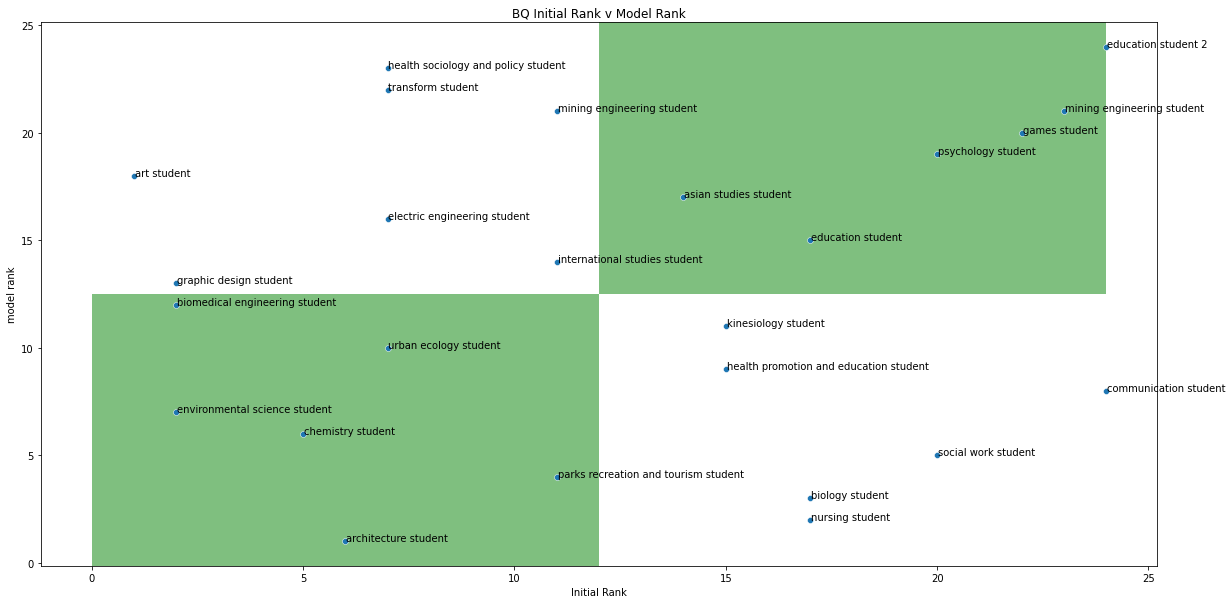

In [92]:
model_evaluations(query_no_words)

In [93]:
#merged_fuzz_cosine

In [94]:
eval_cosine_pd_no_process = model_bq
eval_cosine_pd_no_process

,model rank,name,Initial Rank
0,18.0,art student,1
1,13.0,graphic design student,2
2,12.0,biomedical engineering student,2
3,7.0,environmental science student,2
4,6.0,chemistry student,5
5,1.0,architecture student,6
6,16.0,electric engineering student,7
7,22.0,transform student,7
8,10.0,urban ecology student,7
9,23.0,health sociology and policy student,7


In [95]:
new_row = pandas.Series({'name': 'cosine no process pd words only', 
                         'kendall': tau, 
                         "kendall p-value" : kendall_p_value,
                         'spearman': spearman, 
                         "spearman p-value": spearman_p_value,
                         'pearson':pearson,
                         'pearson p-value': pearson_p_value })

model_eval_results_df = append_row(model_eval_results_df, new_row)
model_eval_results_df

,name,kendall,kendall p-value,spearman,spearman p-value,pearson,pearson p-value
0,jaccard processed,-0.030994,0.832449,0.023580,0.910920,0.041479,0.843935
1,cosine no process all words,-0.182522,0.212816,-0.212604,0.307576,-0.212226,0.308458
2,cosine no process all words count,-0.079208,0.588744,-0.067260,0.749389,-0.067379,0.748961
3,cosine no process all words nltk stop words,-0.182522,0.212816,-0.212604,0.307576,-0.212226,0.308458
4,cosine no process pd words only,0.079208,0.588744,0.125629,0.549595,0.118178,0.573698


# Compare jaccard and cosine similarity and their relationship to number of words

Text(0.5, 1.0, 'jaccard similarity')

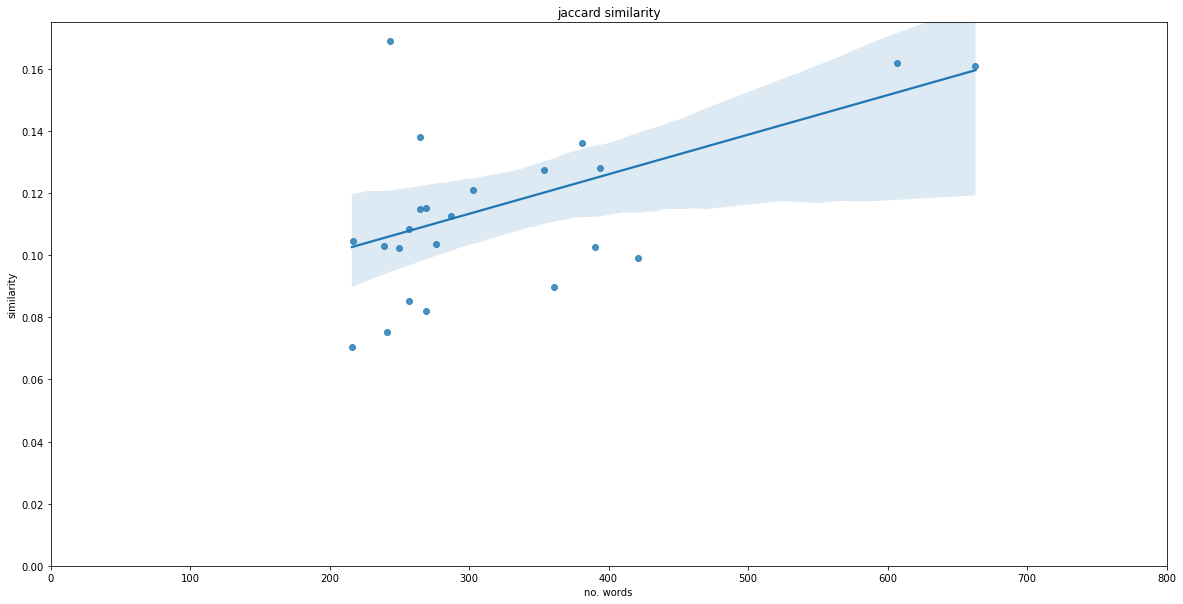

In [96]:
#plot jaccard similarity results and then TFIDF / cosine similarity scores (similarity between pd and each resume) with
#number of words. Expect to see less of a relationship between number of words and similarity scores wtih cosine similarity
#because cosine similarity is supposed to control for number of words more. 

import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(20, 10))

plt.xlim(0,800)
plt.ylim(0,0.175)
#fig, ax = plt.subplots(figsize=(10, 5))

sp_parsed_df_lem_stem_sim = sns.regplot(x=parsed_df_lem_stem_sim['no. words'], y=parsed_df_lem_stem_sim['similarity']).set_title('jaccard similarity')

#label datapoints
# def label_point(x, y, val, ax):
#     a = pandas.concat({'x': x, 'y': y, 'val': val}, axis=1)
#     for i, point in a.iterrows():
#         ax.text(point['x']+.02, point['y'], str(point['val']))
        
# label_point(parsed_df_lem_stem_sim['no. words'], parsed_df_lem_stem_sim['similarity'], parsed_df_lem_stem_sim.name, plt.gca()) 
        
sp_parsed_df_lem_stem_sim

Text(0.5, 1.0, 'TFIDF and cosine similarity')

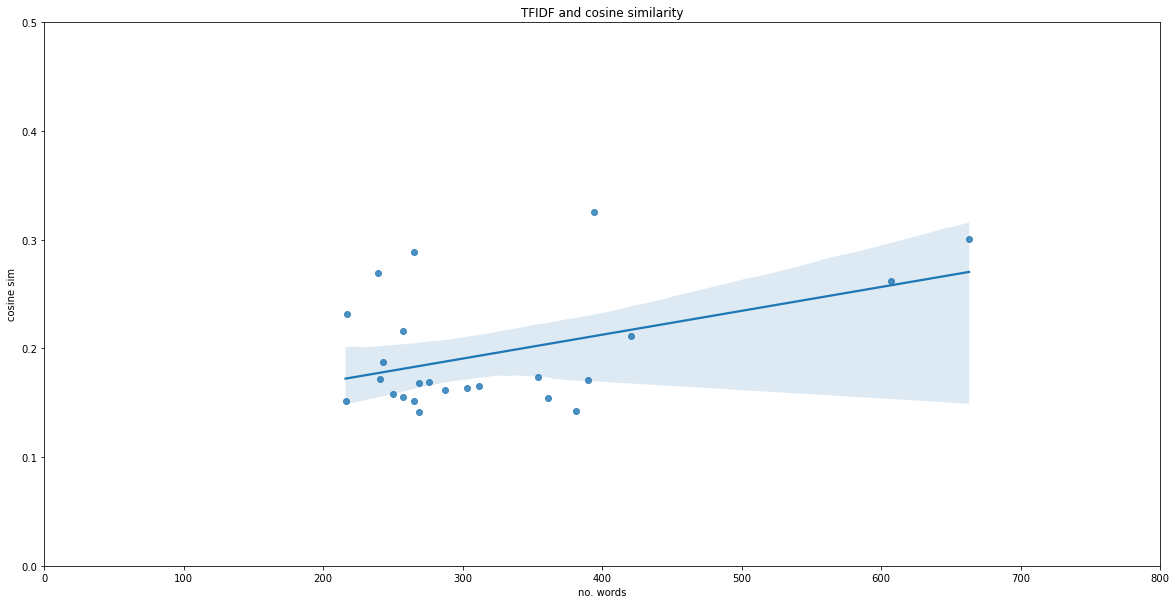

In [97]:
#query_no_words
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(20, 10))

sp_query_cosine_tfidf = sns.regplot(x=query_no_words['no. words'], y=query_no_words['cosine sim']).set_title('TFIDF and cosine similarity')

# label data points using function above
# label_point(query_no_words['no. words'], query_no_words['cosine sim'], query_no_words.name, plt.gca()) 


plt.xlim(0,800)
plt.ylim(0,0.5)
sp_query_cosine_tfidf

# Playing around with masking names
## To ensure a level of anonymity, names can be masked 

In [98]:
import names
names.get_full_name()

'Gary Presley'

In [99]:
#generate a fake name for each applicant
names_parsed_df = parsed_df.copy(deep = True)
names_parsed_df.insert(1, 'false name', names.get_full_name())
names_parsed_df['false name'] = names_parsed_df.apply(lambda row: names.get_full_name(), axis=1)

names_parsed_df

,name,false name,value
0,nursing student,Kenneth Gary,nursing student salt lake city ut 555 5555 nursingstudent utah edu www linkedin com in ...
1,social work student,Robert Witt,social work student salt lake city ut socialworkstudent2 domain com 555 555 5555 educati...
2,health society and policy student,Maria Thorn,health society and policy student salt lake city ut 555 555 5555 policystude...
3,communication student,Charles Bessick,communication student salt lake city ut 555 555 5555 studentemail gmai com education b...
4,asian studies student,Robert Mattson,asian studies student may 20xx salt lake city ut ...
5,gamestudent,Gloria Chin,gamestudent1 email com coolkid com linkedin com in coolkid education masters in entertainm...
6,biomedical engineering student,Maxine Mata,biomedical engineering student biomedstudent1 domain com 555 55 5555 education b s bio...
7,graphic design student,Amanda Darrigo,graphic design student salt lake city ut 801 555 5555 graphicdesign email com myportfo...
8,electrical engineering student,Michael Merritt,electrical engineering student salt lake city utah 555 555 5555 electricalengineeringstud...
9,international studies student,Tammy Hernandez,international studies student salt lake city utah 555 555 5555 internationalstudies gmail ...


## TF-IDF and Cosine Similairty after lemmetization and stemming
### All words

In [100]:
#Calculate TFIDF / cosine similarity after lemmatizing and stemming the pd and each resume
#de-tokenize pd
position_description_lem_stem_detoken = TreebankWordDetokenizer().detokenize(position_description_lem_stem)
parsed_df_lem_stem_sim_detoken = parsed_df_lem_stem_sim.copy(deep = True)
parsed_df_lem_stem_sim_detoken["value"] = parsed_df_lem_stem_sim_detoken.apply(lambda row: TreebankWordDetokenizer().detokenize((row['value'])), axis=1)
#convert position description from list to df
position_description_lem_stem_df = pandas.DataFrame([position_description_lem_stem_detoken])
#add label for position description
position_description_lem_stem_df.insert(0, "name", ["position description"], True)
#rename columns of the position description df
position_description_lem_stem_df.columns = ["name", "value"]
#Concatanate position description dataframe to the resumes dataframe
combo_parsed_pd_lem_stem = pandas.concat([position_description_lem_stem_df, parsed_df_lem_stem_sim_detoken], ignore_index=True)
combo_parsed_pd_lem_stem = combo_parsed_pd_lem_stem[['name','value']]

combo_parsed_pd_lem_stem

,name,value
0,position description,titl classif salari rang manag employ equiti manag team classifi supervisori rang job descript g...
1,education student,educ student salt lake citi ut gmail com master educ educ leadership polici student affair unive...
2,health promotion and education student,health promot educ student salt lake citi ut gmail com bachelor scienc health promot educ may un...
3,social work student,social work student salt lake citi ut domain com educ bachelor scienc pre major social work univ...
4,nursing student,nurs student salt lake citi ut nursingstud utah edu www linkedin com nursingstampl educ bachelor...
5,biology student,biolog student salt lake citi ut domain com educ bachelor scienc biolog univers utah minor envir...
6,health society and policy student,health societi polici student salt lake citi ut email com educ honor b health societi polici may...
7,architechture student,architechtur student presid circl salt lake citi ut name gmail com www myportfolio com architech...
8,urban ecology student,urban ecolog student salt lake citi utah urbanecologystud gmail com educ b urban ecolog minor st...
9,electrical engineering student,electr engin student salt lake citi utah domain com educ honor b electr engin minor polit scienc...


In [101]:
#Calculate tfidf using all words in both the pd and each resume. Result is a vector space model. It is a sparse matrix. 

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', lowercase = False)
tfidf_matrix_ls = tfidf_vectorizer.fit_transform(combo_parsed_pd_lem_stem['value'])
tfidf_term_matrix_ls = tfidf_matrix_ls.todense()
df_tfidf_matrix_ls = pandas.DataFrame(tfidf_term_matrix_ls, 
                  columns=tfidf_vectorizer.get_feature_names_out()) 

#pandas.options.display.max_rows = 50 #5
pandas.options.display.max_columns = 100 #3000
df_tfidf_matrix_ls

,aba,abil,abnorm,abroad,absenc,abus,academ,academi,accept,access,accid,accommod,accord,account,accredit,accur,accuraci,achiev,acid,acquir,act,action,activ,ad,adapt,addit,address,adher,adjust,administ,administr,admiss,admit,adob,adolesc,adult,advanc,adventur,advers,advertis,advic,advis,advisor,advisori,advoc,advocaci,aerob,afb,affair,affect,...,warm,wasatch,washington,water,watter,weather,web,webinar,websit,week,weekend,weight,welcom,welfar,wellb,west,western,wet,wide,wilder,william,window,winona,wireless,withdrawn,woman,wood,word,work,worker,workforc,workout,workshop,workup,world,wound,wrapper,write,writer,written,wrote,www,xrpd,year,young,youth,youthclinc,ystre,zealand,zoo
0,0.000000,0.044041,0.00000,0.000000,0.024846,0.000000,0.017189,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.0000,0.017189,0.044041,0.000000,0.000000,0.000000,0.000000,0.000000,0.051859,0.020015,0.000000,0.018460,0.000000,0.00000,0.000000,0.000000,0.02202,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.024846,0.088081,0.000000,0.000000,0.000000,0.022020,0.000000,0.000000,0.000000,0.000000,0.00000,0.024846,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.051568,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.020015,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.038895,0.000000,0.024846,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.055380,0.00000,0.020015,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.123450,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.11896,0.0000,0.041150,0.105430,0.000000,0.000000,0.000000,0.000000,0.000000,0.031037,0.000000,0.000000,0.044192,0.036350,0.05948,0.105430,0.000000,0.00000,0.044192,0.052715,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.088384,0.047915,0.000000,0.044192,0.000000,0.000000,0.000000,0.17844,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.05948,0.041150,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.05948,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.028250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.076708,0.000000,0.00000,0.000000,0.000000,0.000000,0.053069,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.0000,0.000000,0.000000,0.053069,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.056992,0.046879,0.00000,0.000000,0.099504,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.036432,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.056992,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.026931,0.000000,0.000000,0.000000,0.038927,0.00000,0.000000,0.00000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.101562,0.000000,0.034500,0.000000,0.047579,0.00000,0.000000,0.000000,0.03450,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.028922,0.031358,0.000000,0.028922,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.240347,0.000000,0.000000,0.000000,0.00000,0.000000,0.057844,0.000000,0.000000,0.000000,0.000000,0.000000,0.00

In [102]:
# Actually doing the cosine similarity comparisons now:
#cosine similarity (CS) = (A . B) / (||A|| ||B||) = dotproduct of vectors / (sqrt of first vector *sqrt of second vector)

from sklearn.metrics.pairwise import cosine_similarity
cosine_sim_ls =pandas.DataFrame(cosine_similarity(df_tfidf_matrix_ls, dense_output=True))

cosine_sim_ls #.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,1.000000,0.130738,0.118760,0.144592,0.116996,0.126733,0.105247,0.120171,0.080411,0.086269,0.105716,0.112091,0.114504,0.063327,0.096664,0.063013,0.078453,0.092314,0.055999,0.072449,0.045873,0.055094,0.070912,0.033201,0.042611
1,0.130738,1.000000,0.176680,0.229695,0.190492,0.188375,0.229173,0.115992,0.191962,0.149511,0.220043,0.281427,0.233336,0.142745,0.160627,0.180249,0.107993,0.191322,0.124812,0.192287,0.037472,0.118169,0.159384,0.101135,0.087971
2,0.118760,0.176680,1.000000,0.244558,0.225391,0.187079,0.258390,0.125018,0.193941,0.118199,0.139765,0.149757,0.149622,0.199244,0.132351,0.203294,0.129340,0.105702,0.134637,0.200091,0.072106,0.108324,0.093991,0.130808,0.096234
3,0.144592,0.229695,0.244558,1.000000,0.259126,0.203226,0.340073,0.171548,0.227558,0.242606,0.227707,0.310108,0.250036,0.205557,0.170995,0.195669,0.131416,0.161760,0.150628,0.183503,0.060443,0.125929,0.147281,0.098238,0.092731
4,0.116996,0.190492,0.225391,0.259126,1.000000,0.125484,0.260534,0.099444,0.145822,0.118128,0.309842,0.175741,0.177887,0.213364,0.139533,0.147814,0.193992,0.193802,0.082483,0.151869,0.049223,0.144385,0.240055,0.234449,0.083813
5,0.126733,0.188375,0.187079,0.203226,0.125484,1.000000,0.223951,0.122227,0.210043,0.148784,0.148866,0.198445,0.153909,0.177487,0.178929,0.198220,0.113062,0.109630,0.115467,0.210619,0.054588,0.163177,0.082110,0.084535,0.094913
6,0.105247,0.229173,0.258390,0.340073,0.260534,0.223951,1.000000,0.141288,0.247407,0.258600,0.210430,0.272068,0.313281,0.187538,0.217100,0.205730,0.110451,0.248016,0.196571,0.258822,0.090476,0.151166,0.216362,0.114919,0.159947
7,0.120171,0.115992,0.125018,0.171548,0.099444,0.122227,0.141288,1.000000,0.168677,0.174047,0.095817,0.119478,0.073090,0.067830,0.105524,0.235605,0.079136,0.146815,0.169944,0.175170,0.107532,0.097737,0.055922,0.062084,0.142777
8,0.080411,0.191962,0.193941,0.227558,0.145822,0.210043,0.247407,0.168677,1.000000,0.191383,0.245373,0.211306,0.178594,0.173331,0.188655,0.252190,0.089365,0.205956,0.168982,0.219407,0.042623,0.133739,0.134103,0.130143,0.113210
9,0.086269,0.149511,0.118199,0.242606,0.118128,0.148784,0.258600,0.174047,0.191383,1.000000,0.133268,0.224591,0.140591,0.103842,0.122103,0.157817,0.094104,0.215268,0.160244,0.244982,0.119781,0.119457,0.159367,0.101043,0.206715


In [103]:
#convert cosine similarity matrix to results

#join cosine results to original dataframe
join_data_cosine_ls = pandas.concat([combo_parsed_pd_lem_stem, cosine_sim_ls], axis=1, ignore_index=True)
#drop column with text
join_data_cosine_ls.drop(join_data_cosine_ls.columns[1], axis=1, inplace = True)
#make first column of names a list
column_headers = join_data_cosine_ls[0].tolist()
#add a "name" placeholder for first column
column_headers.insert(0, 'name')
#make list of names column headers 
join_data_cosine_ls.columns = column_headers
#only keep first row data, which is the similarity scores for the position description
position_description_cosine_ls = join_data_cosine_ls.head(1)
#transpose so columns are rows
position_description_cosine_ls = position_description_cosine_ls.T
#reset index
position_description_cosine_ls = position_description_cosine_ls.reset_index(drop = False)
#rename columns
position_description_cosine_ls.columns = ["name", "cosine sim"]
#drop the first row, which are just additional labels 
position_description_cosine_ls = position_description_cosine_ls.drop(0)
#Convert cosine similarity score to numeric
position_description_cosine_ls["cosine sim"] = pandas.to_numeric(position_description_cosine_ls["cosine sim"])
#Sort cosine similarity values from large
position_description_cosine_ls = position_description_cosine_ls.sort_values(by=['cosine sim'], ascending=False)
#adding number of words
parsed_df_word_count = parsed_df_lem_sim[['name','no. words']]
position_description_cosine_ls = pandas.merge(position_description_cosine_ls, parsed_df_word_count, on=['name'])

position_description_cosine_ls#.dtypes

,name,cosine sim,no. words
0,social work student,0.144592,607
1,education student,0.130738,312
2,biology student,0.126733,265
3,architechture student,0.120171,394
4,health promotion and education student,0.118760,243
5,nursing student,0.116996,663
6,asian studies student,0.114504,287
7,transform student,0.112091,265
8,international studies student,0.105716,269
9,health society and policy student,0.105247,381


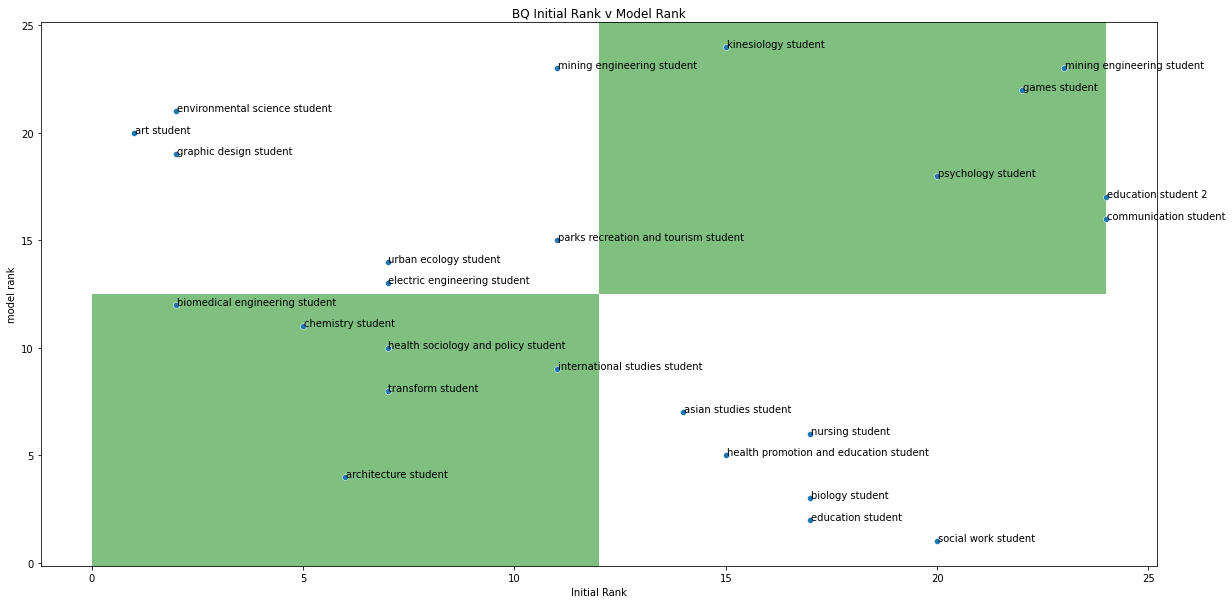

In [104]:
model_evaluations(position_description_cosine_ls)


In [105]:
#merged_fuzz_cosine

In [106]:
eval_cosine_all_processed = model_bq
eval_cosine_all_processed

,model rank,name,Initial Rank
0,20.0,art student,1
1,21.0,environmental science student,2
2,19.0,graphic design student,2
3,12.0,biomedical engineering student,2
4,11.0,chemistry student,5
5,4.0,architecture student,6
6,13.0,electric engineering student,7
7,8.0,transform student,7
8,10.0,health sociology and policy student,7
9,14.0,urban ecology student,7


In [107]:
new_row = pandas.Series({'name': 'cosine processed all words', 
                         'kendall': tau, 
                         "kendall p-value" : kendall_p_value,
                         'spearman': spearman, 
                         "spearman p-value": spearman_p_value,
                         'pearson':pearson,
                         'pearson p-value': pearson_p_value })

model_eval_results_df = append_row(model_eval_results_df, new_row)
model_eval_results_df

,name,kendall,kendall p-value,spearman,spearman p-value,pearson,pearson p-value
0,jaccard processed,-0.030994,0.832449,0.023580,0.910920,0.041479,0.843935
1,cosine no process all words,-0.182522,0.212816,-0.212604,0.307576,-0.212226,0.308458
2,cosine no process all words count,-0.079208,0.588744,-0.067260,0.749389,-0.067379,0.748961
3,cosine no process all words nltk stop words,-0.182522,0.212816,-0.212604,0.307576,-0.212226,0.308458
4,cosine no process pd words only,0.079208,0.588744,0.125629,0.549595,0.118178,0.573698
5,cosine processed all words,-0.079208,0.588744,-0.026286,0.900745,-0.020374,0.922993


## TF-IDF and Cosine Similairty after lemmetization and stemming
### PD words only - PD as query

In [108]:
#Calculate tfidf / cosine similaritizing after lemmatizing and stemming the pd and each resume. This time, build the
#model only using words from the pd.

from sklearn.feature_extraction.text import TfidfVectorizer

#instantiate the model
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
#tfidf_vectorizer = TfidfVectorizer()
#fit the model
pd_query_tfidf_matrix_ls = tfidf_vectorizer.fit_transform(position_description_lem_stem_df['value'])

pd_query_tfidf_matrix_ls  = pd_query_tfidf_matrix_ls.todense()
pd_query_tfidf_matrix_ls  = pandas.DataFrame(pd_query_tfidf_matrix_ls, 
                  columns=tfidf_vectorizer.get_feature_names_out()) 

#pd_query_tfidf_matrix = pd_query_tfidf_matrix.transform([position_description_no_stop_df])

pd_query_tfidf_matrix_ls


,abil,absenc,academ,accur,accuraci,activ,ad,addit,administr,advers,advertis,advisori,affect,ambigu,analyz,announc,appli,applic,appropri,approv,area,assess,assign,assist,associ,bachelor,backup,basi,behalf,behavior,board,broad,budget,candid,chair,clarifi,classif,classifi,collabor,colleg,combin,committe,communic,compet,complet,comprehens,conduct,confer,confirm,consider,...,respons,restrict,retent,review,revis,salari,scope,screen,section,select,senat,sensit,serf,session,sheet,skill,softwar,sourc,specif,staff,standard,state,streamlin,student,submiss,suggest,supervis,supervisori,survey,task,team,techniqu,test,time,timelin,titl,topic,train,union,updat,vacanc,various,verifi,vice,websit,wide,work,workforc,write,written
0,0.035153,0.017576,0.017576,0.017576,0.035153,0.070305,0.017576,0.017576,0.017576,0.017576,0.070305,0.017576,0.017576,0.017576,0.035153,0.035153,0.017576,0.158187,0.017576,0.052729,0.035153,0.035153,0.052729,0.035153,0.017576,0.017576,0.017576,0.035153,0.017576,0.017576,0.035153,0.017576,0.017576,0.070305,0.017576,0.017576,0.017576,0.105458,0.017576,0.035153,0.017576,0.158187,0.035153,0.035153,0.017576,0.017576,0.017576,0.017576,0.017576,0.017576,...,0.087882,0.017576,0.035153,0.070305,0.017576,0.070305,0.017576,0.035153,0.017576,0.087882,0.017576,0.017576,0.140611,0.017576,0.017576,0.017576,0.017576,0.035153,0.035153,0.228493,0.017576,0.017576,0.017576,0.035153,0.017576,0.017576,0.105458,0.017576,0.017576,0.017576,0.017576,0.035153,0.017576,0.035153,0.035153,0.017576,0.017576,0.140611,0.017576,0.035153,0.017576,0.017576,0.017576,0.017576,0.052729,0.017576,0.052729,0.017576,0.052729,0.017576


In [109]:
from sklearn.feature_extraction.text import TfidfVectorizer
parsed_df_no_stop_test_matrix_ls = tfidf_vectorizer.transform(parsed_df_lem_stem_sim_detoken['value'])
parsed_df_no_stop_test_matrix_ls  = parsed_df_no_stop_test_matrix_ls.todense()
parsed_df_no_stop_test_matrix_ls = pandas.DataFrame(parsed_df_no_stop_test_matrix_ls, 
                  columns=tfidf_vectorizer.get_feature_names_out()) 


#pandas.options.display.max_rows = 50 #5
#pandas.options.display.max_columns = 2000 #3000
parsed_df_no_stop_test_matrix_ls

,abil,absenc,academ,accur,accuraci,activ,ad,addit,administr,advers,advertis,advisori,affect,ambigu,analyz,announc,appli,applic,appropri,approv,area,assess,assign,assist,associ,bachelor,backup,basi,behalf,behavior,board,broad,budget,candid,chair,clarifi,classif,classifi,collabor,colleg,combin,committe,communic,compet,complet,comprehens,conduct,confer,confirm,consider,...,respons,restrict,retent,review,revis,salari,scope,screen,section,select,senat,sensit,serf,session,sheet,skill,softwar,sourc,specif,staff,standard,state,streamlin,student,submiss,suggest,supervis,supervisori,survey,task,team,techniqu,test,time,timelin,titl,topic,train,union,updat,vacanc,various,verifi,vice,websit,wide,work,workforc,write,written
0,0.000000,0.0,0.103510,0.034503,0.069007,0.034503,0.000000,0.034503,0.0000,0.0,0.000000,0.00000,0.0,0.0,0.069007,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.034503,0.000000,0.069007,0.000000,0.034503,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.069007,0.0,0.000000,0.034503,0.000000,0.069007,0.034503,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.034503,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.034503,0.000000,0.034503,0.069007,0.828079,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.103510,0.0,0.0,0.00000,0.034503,0.000000,0.034503,0.0,0.000000,0.0,0.000000,0.034503,0.000000,0.000000,0.0,0.000000,0.00000
1,0.000000,0.0,0.071429,0.000000,0.000000,0.000000,0.000000,0.071429,0.0000,0.0,0.000000,0.00000,0.0,0.0,0.071429,0.0,0.071429,0.000000,0.000000,0.0,0.000000,0.071429,0.000000,0.000000,0.071429,0.071429,0.0,0.000000,0.0,0.142857,0.071429,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.071429,0.000000,0.0,0.000000,0.142857,0.000000,0.000000,0.000000,0.071429,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.142857,0.0,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,0.071429,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.142857,0.000000,0.071429,0.000000,0.0,0.0,0.00000,0.071429,0.000000,0.142857,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000
2,0.000000,0.0,0.035400,0.000000,0.000000,0.176998,0.000000,0.000000,0.0354,0.0,0.000000,0.00000,0.0,0.0,0.035400,0.0,0.000000,0.106199,0.035400,0.0,0.070799,0.000000,0.000000,0.070799,0.000000,0.035400,0.0,0.000000,0.0,0.035400,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.141598,0.106199,0.0,0.035400,0.035400,0.000000,0.141598,0.000000,0.035400,0.000000,0.0,0.0,...,0.035400,0.0,0.000000,0.035400,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.141598,0.000000,0.000000,0.000000,0.035400,0.000000,0.000000,0.000000,0.353996,0.0,0.0,0.000000,0.0,0.070799,0.035400,0.035400,0.000000,0.035400,0.035400,0.0,0.0,0.03540,0.106199,0.000000,0.106199,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.070799,0.0,0.000000,0.03540
3,0.000000,0.0,0.038462,0.000000,0.000000,0.038462,0.000000,0.000000,0.0000,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.076923,0.0,0.000000,0.269231,0.038462,0.115385,0.076923,0.038462,0.0,0.000000,0.0,0.000000,0.038462,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.076923,0.076923,0.0,0.076923,0.076923,0.000000,0.076923,0.000000,0.115385,0.038462,0.0,0.0,...,0.076923,0.0,0.038462,0.038462,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.038462,0.0,0.000000,0.0,0.115385,0.000000,0.000000,0.038462,0.115385,0.038462,0.076923,0.000000,0.384615,0.0,0.0,0.076923,0.0,0.000000,0.000000,0.000000,0.038462,0.192308,0.000000,0.0,0.0,0.00000,0.076923,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.076923,0.000000,0.0,0.000000,0.00000
4,0.000000,0.0,0.000000,0.088045,0.000000,0.088045,0.000000,0.000000,0.0000,0.0,0.000000,0.00000,0.0,0.0,0.176090,0.0,0.000000,0.176090,0.000000,0.0,0.088045,0.000000,0.000000,0.176090,0.088045,0.088045,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0

In [110]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim_pd_query_ls = pandas.DataFrame(cosine_similarity(pd_query_tfidf_matrix_ls, parsed_df_no_stop_test_matrix_ls, dense_output=True))
cosine_sim_pd_query_ls

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,0.200732,0.300053,0.344074,0.37992,0.402353,0.279784,0.342375,0.24456,0.233717,0.285475,0.249189,0.229448,0.247051,0.304151,0.212088,0.330881,0.22694,0.230096,0.237461,0.24041,0.296446,0.15095,0.247187,0.159205


In [111]:
#join cosine results to original dataframe
join_cosine_sim_pd_query_ls = pandas.concat([parsed_df_no_stop, cosine_sim_pd_query_ls], axis=1, ignore_index=True)
#drop column with text
join_cosine_sim_pd_query_ls.drop(join_cosine_sim_pd_query_ls.columns[1], axis=1, inplace = True)
#make first column of names a list
column_headers_no_stop_query_ls = join_cosine_sim_pd_query_ls[0].tolist()
#add a "name" placeholder for first column
column_headers_no_stop_query_ls.insert(0, 'name')
#make list of names column headers 
join_cosine_sim_pd_query_ls.columns = column_headers_no_stop_query_ls
#only keep first row data, which is the similarity scores for the position description
query_labeled_cosine_no_stop_ls = join_cosine_sim_pd_query_ls.head(1)
#transpose so columns are rows
query_labeled_cosine_no_stop_ls = query_labeled_cosine_no_stop_ls.T
#reset index
query_labeled_cosine_no_stop_ls = query_labeled_cosine_no_stop_ls.reset_index(drop = False)
#rename columns
query_labeled_cosine_no_stop_ls.columns = ["name", "cosine sim"]
#drop the first row, which are just additional labels 
query_labeled_cosine_no_stop_ls = query_labeled_cosine_no_stop_ls.drop(0)
#Convert cosine similarity score to numeric
query_labeled_cosine_no_stop_ls["cosine sim"] = pandas.to_numeric(query_labeled_cosine_no_stop_ls["cosine sim"])
#Sort cosine similarity values from large
query_labeled_cosine_no_stop_ls = query_labeled_cosine_no_stop_ls.sort_values(by=['cosine sim'], ascending=False)

query_labeled_cosine_no_stop_ls.reset_index(drop=True, inplace=True)



query_labeled_cosine_no_stop_ls

,name,cosine sim
0,asian studies student,0.402353
1,communication student,0.379920
2,health society and policy student,0.344074
3,biomedical engineering student,0.342375
4,education student 2,0.330881
5,education student,0.304151
6,social work student,0.300053
7,psychology student,0.296446
8,international studies student,0.285475
9,gamestudent,0.279784


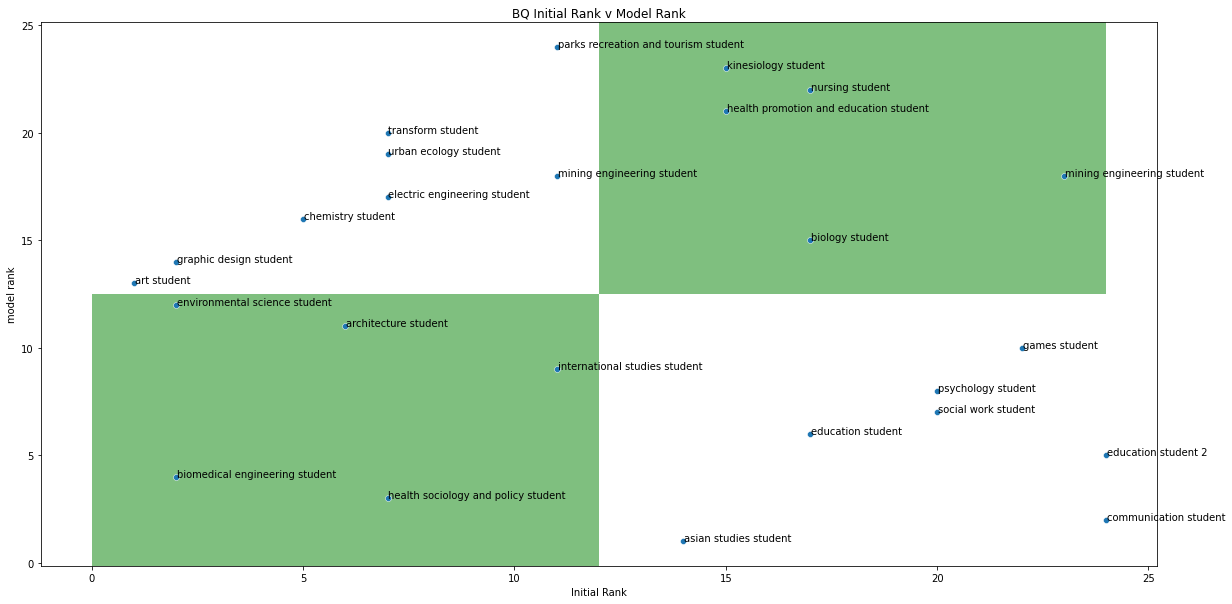

In [112]:
model_evaluations(query_labeled_cosine_no_stop_ls)

In [113]:
merged_fuzz_cosine

,model rank,name
0,1.0,asian studies student
1,2.0,communication student
2,3.0,health sociology and policy student
3,4.0,biomedical engineering student
4,5.0,education student 2
5,6.0,education student
6,7.0,social work student
7,8.0,psychology student
8,9.0,international studies student
9,10.0,games student


In [114]:
query_labeled_cosine_no_stop_ls_bq = model_bq
query_labeled_cosine_no_stop_ls_bq

,model rank,name,Initial Rank
0,13.0,art student,1
1,4.0,biomedical engineering student,2
2,14.0,graphic design student,2
3,12.0,environmental science student,2
4,16.0,chemistry student,5
5,11.0,architecture student,6
6,20.0,transform student,7
7,3.0,health sociology and policy student,7
8,19.0,urban ecology student,7
9,17.0,electric engineering student,7


In [115]:
new_row = pandas.Series({'name': 'cosine processed pd words only', 
                         'kendall': tau, 
                         "kendall p-value" : kendall_p_value,
                         'spearman': spearman, 
                         "spearman p-value": spearman_p_value,
                         'pearson':pearson,
                         'pearson p-value': pearson_p_value })

model_eval_results_df = append_row(model_eval_results_df, new_row)
model_eval_results_df

,name,kendall,kendall p-value,spearman,spearman p-value,pearson,pearson p-value
0,jaccard processed,-0.030994,0.832449,0.023580,0.910920,0.041479,0.843935
1,cosine no process all words,-0.182522,0.212816,-0.212604,0.307576,-0.212226,0.308458
2,cosine no process all words count,-0.079208,0.588744,-0.067260,0.749389,-0.067379,0.748961
3,cosine no process all words nltk stop words,-0.182522,0.212816,-0.212604,0.307576,-0.212226,0.308458
4,cosine no process pd words only,0.079208,0.588744,0.125629,0.549595,0.118178,0.573698
5,cosine processed all words,-0.079208,0.588744,-0.026286,0.900745,-0.020374,0.922993
6,cosine processed pd words only,-0.079208,0.588744,-0.142251,0.497578,-0.163062,0.436095


## polyangulation / triangulation

### referring to this as "polyangulation" because averaging the results of more than 3 models

In [116]:
#Combine all the model results in one dataframe
eval_jaccard_bq = jaccard_bq.rename(columns={'jaccard rank': 'model rank'})

cosine_tri = pandas.concat([eval_jaccard_bq,
                            eval_all_cosine_no_process, 
                            eval_all_cosine_count, 
                            eval_cosine_nltk_all,
                            eval_cosine_all_processed, 
                            query_labeled_cosine_no_stop_ls_bq])

eval_model_tri = pandas.concat([cosine_tri, eval_jaccard_bq])

eval_model_tri  = eval_model_tri.sort_values(by=['name'], ascending=True)
eval_model_tri_all = eval_model_tri
eval_model_tri_all.head(15)


,model rank,name,Initial Rank
5,11.0,architecture student,6
5,5.0,architecture student,6
5,4.0,architecture student,6
5,4.0,architecture student,6
5,7.0,architecture student,6
5,4.0,architecture student,6
5,7.0,architecture student,6
0,20.0,art student,1
0,18.0,art student,1
0,18.0,art student,1


In [117]:
#calculate the average rank of all the models and standard deviation

eval_model_tri = eval_model_tri_all.groupby(['name'], as_index=False).agg(
                      {'model rank':['mean','std']})

#eval_model_tri = eval_model_tri[eval_model_tri['name'] != "christopher  hershey"]
#eval_model_tri = eval_model_tri[eval_model_tri['name'] != "phaedra y pitre"]
eval_model_tri.columns = ['name','mean','std']
eval_model_tri  = eval_model_tri.sort_values(by=['std'], ascending = False)
eval_model_tri['model rank'] = eval_model_tri['mean'].rank(ascending = True)
eval_model_tri = eval_model_tri.sort_values(by=['model rank'], ascending = True)
eval_model_tri.reset_index(drop=True, inplace=True)

eval_model_tri

,name,mean,std,model rank
0,education student,2.142857,1.772811,1.0
1,social work student,2.714286,2.138090,2.0
2,biology student,5.428571,4.314979,3.0
3,architecture student,6.000000,2.581989,4.0
4,asian studies student,7.285714,3.817254,5.0
5,nursing student,7.428571,6.477066,6.0
6,health promotion and education student,8.000000,6.480741,7.0
7,health sociology and policy student,10.714286,5.964179,8.0
8,international studies student,11.428571,2.636737,9.0
9,transform student,12.000000,3.785939,10.0


In [118]:
#create a new function to compare results of the average of all models to the bq panel. A new function is needed because
#some of the processing done in the previous function is not needed / it's already been done. 
def model_evaluations_hex(model_output):

    global merged_fuzz_cosine, model_bq, plot_model_bq, spearman, pearson, tau, kendall_p_value, spearman_p_value, pearson_p_value

    #process model output. Already matched to original name list.
    model_output = model_output[model_output['name'] != "william m   tho"]#incorrect parse
    model_output = model_output[model_output['name'] != "position description"] #remove pd to avoid throwing off ranking
    model_output['model rank'] = model_output['model rank'].rank(ascending = True)
    model_output = model_output[["name", "model rank"]]

    #merge cosine results with bq panel rank
    model_output['name'] = model_output['name'].apply(lambda x: difflib.get_close_matches(x, ea_df_strip['name'])[0])
    model_bq = pandas.merge(model_output, ea_df_strip, on = 'name', how = 'outer') #merge jaccard with bq panel rankings
    model_bq = model_bq.sort_values(by=['Initial Rank'], ascending = True)
    model_bq = model_bq.reset_index(drop=True)

    #plot the model/bq results
    fig, ax = plt.subplots(figsize=(20, 10))
   # plt.axhline(y=25) 
   # plt.axvline(x=25) 
    plt.axvspan(xmin = 0, xmax = 12, ymin=0, ymax = 0.5, facecolor='g', alpha=0.5)
    plt.axvspan(xmin = 12, xmax = 24, ymin=0.5, ymax = 1, facecolor='g', alpha=0.5)
    plot_model_bq = sns.scatterplot(x=model_bq['Initial Rank'], y=model_bq['model rank']).set_title('BQ Initial Rank v Model Rank')
    label_point(model_bq['Initial Rank'], model_bq['model rank'], model_bq.name, plt.gca()) 

    #calculate ranking coeficients. -1 to 1. Closer to 0 means weaker association
    model_bq = model_bq.dropna(subset=['model rank'])
    tau, kendall_p_value = kendalltau(model_bq['Initial Rank'], model_bq['model rank'], variant ='b')
    spearman, spearman_p_value = stats.spearmanr(model_bq['Initial Rank'], model_bq['model rank'])
    pearson, pearson_p_value = stats.pearsonr(model_bq['Initial Rank'], model_bq['model rank'])

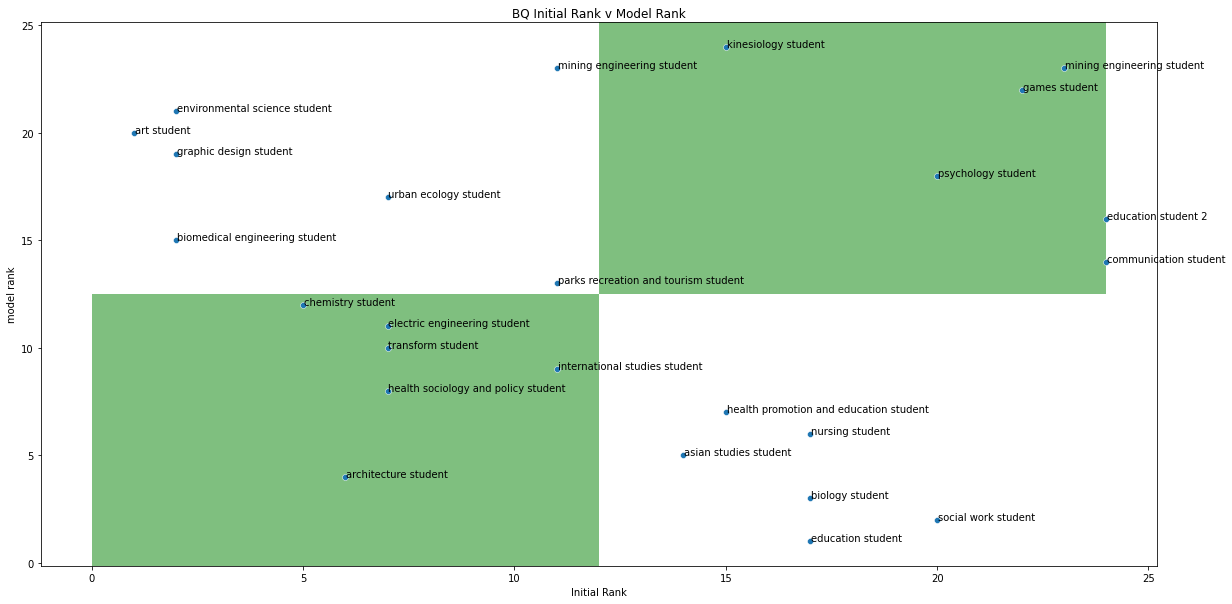

In [119]:
model_evaluations_hex(eval_model_tri)

In [120]:
model_bq

,name,model rank,Initial Rank
0,art student,20.0,1
1,environmental science student,21.0,2
2,graphic design student,19.0,2
3,biomedical engineering student,15.0,2
4,chemistry student,12.0,5
5,architecture student,4.0,6
6,health sociology and policy student,8.0,7
7,transform student,10.0,7
8,electric engineering student,11.0,7
9,urban ecology student,17.0,7


In [121]:
new_row = pandas.Series({'name': 'hexangulation', 
                         'kendall': tau, 
                         "kendall p-value" : kendall_p_value,
                         'spearman': spearman, 
                         "spearman p-value": spearman_p_value,
                         'pearson':pearson,
                         'pearson p-value': pearson_p_value })

model_eval_results_df = append_row(model_eval_results_df, new_row)
model_eval_results_df

,name,kendall,kendall p-value,spearman,spearman p-value,pearson,pearson p-value
0,jaccard processed,-0.030994,0.832449,0.023580,0.910920,0.041479,0.843935
1,cosine no process all words,-0.182522,0.212816,-0.212604,0.307576,-0.212226,0.308458
2,cosine no process all words count,-0.079208,0.588744,-0.067260,0.749389,-0.067379,0.748961
3,cosine no process all words nltk stop words,-0.182522,0.212816,-0.212604,0.307576,-0.212226,0.308458
4,cosine no process pd words only,0.079208,0.588744,0.125629,0.549595,0.118178,0.573698
5,cosine processed all words,-0.079208,0.588744,-0.026286,0.900745,-0.020374,0.922993
6,cosine processed pd words only,-0.079208,0.588744,-0.142251,0.497578,-0.163062,0.436095
7,hexangulation,-0.113646,0.437912,-0.080016,0.703790,-0.075084,0.721312


## Removing outliers from polyangulation
### https://statisticsbyjim.com/basics/outliers/
### The code below removes some of the outlier ranks from the combined ranks generated by the models. Because the data set is so small, there is not enough data to demonstrate that "outliers" are truly outliers that should be removed. However, this code demonstrates that even with removing the outliers, the correlation coefficients remain low.

In [122]:
#z score method to identify outliers. Typically exclude anything with zscore greater than +/- 3. Can be misleading with 
#small datasets. Sample sizes of 10 or fewer observations cannot have Z-scores that exceed a cutoff value of +/-3, 
#demonstrated below

eval_model_tri = eval_model_tri.drop('model rank', axis=1)

#merge thee mean and standard deviation back with list of all model ranks
eval_model_hex_merge = eval_model_tri_all.merge(eval_model_tri, on = 'name', how = 'outer')

#calculate z score for each observation
eval_model_hex_merge["z score"] = (eval_model_hex_merge["model rank"] -
                                   eval_model_hex_merge["mean"])/eval_model_hex_merge["std"]
#sort by z score
# eval_model_hex_merge = eval_model_hex_merge.sort_values(by=['z score'], ascending = False)


eval_model_hex_merge.head()

,model rank,name,Initial Rank,mean,std,z score
0,11.0,architecture student,6,6.0,2.581989,1.936492
1,5.0,architecture student,6,6.0,2.581989,-0.387298
2,4.0,architecture student,6,6.0,2.581989,-0.774597
3,4.0,architecture student,6,6.0,2.581989,-0.774597
4,7.0,architecture student,6,6.0,2.581989,0.387298


In [123]:
#Use IQR to identify outliers

#calculate quantiles
quantile = eval_model_tri_all.groupby("name")["model rank"].quantile([0.25, 0.75]).unstack(level=1)
#rename columns
quantile.columns = ['lower quantile', 'upper quantile']
#calculate IQR
quantile['IQR'] = quantile['upper quantile'] - quantile['lower quantile']
#calculate cut off values
quantile['cut off 1.5'] = quantile['IQR'] * 1.5
quantile['cut off 3.0'] = quantile['IQR'] *3
#calcluate fences
quantile['lower inner fence'] = quantile['lower quantile'] - quantile['cut off 1.5']
quantile['lower outer fence'] = quantile['lower quantile'] - quantile['cut off 3.0']
quantile['upper inner fence'] = quantile['upper quantile'] + quantile['cut off 1.5']
quantile['upper outer fence'] = quantile['upper quantile'] + quantile['cut off 3.0']
#determine if rank is within inner fences
eval_model_hex_merge_quantile = eval_model_tri_all.merge(quantile, on = 'name', how = 'outer')
eval_model_hex_merge_quantile["outlier inner"] = ((eval_model_hex_merge_quantile["model rank"] < 
                                                eval_model_hex_merge_quantile["lower inner fence"]) |
                                                (eval_model_hex_merge_quantile["model rank"] >
                                                eval_model_hex_merge_quantile["upper inner fence"]))
#determine if each rank is within outer fences
eval_model_hex_merge_quantile["outlier outer"] = ((eval_model_hex_merge_quantile["model rank"] < 
                                                eval_model_hex_merge_quantile["lower outer fence"]) |
                                                (eval_model_hex_merge_quantile["model rank"] >
                                                eval_model_hex_merge_quantile["upper outer fence"]))

#eval_model_hex_merge_quantile["outlier outer"].value_counts()

                                               
eval_model_hex_merge_quantile.head()

,model rank,name,Initial Rank,lower quantile,upper quantile,IQR,cut off 1.5,cut off 3.0,lower inner fence,lower outer fence,upper inner fence,upper outer fence,outlier inner,outlier outer
0,11.0,architecture student,6,4.0,7.0,3.0,4.5,9.0,-0.5,-5.0,11.5,16.0,False,False
1,5.0,architecture student,6,4.0,7.0,3.0,4.5,9.0,-0.5,-5.0,11.5,16.0,False,False
2,4.0,architecture student,6,4.0,7.0,3.0,4.5,9.0,-0.5,-5.0,11.5,16.0,False,False
3,4.0,architecture student,6,4.0,7.0,3.0,4.5,9.0,-0.5,-5.0,11.5,16.0,False,False
4,7.0,architecture student,6,4.0,7.0,3.0,4.5,9.0,-0.5,-5.0,11.5,16.0,False,False


In [124]:
#Count number of "outliers" there are, true statement
eval_model_hex_merge_quantile["outlier outer"].value_counts()

False    168
True       7
Name: outlier outer, dtype: int64

In [125]:
#remove any outliers outside of outer fence. For the first set of resumes, ~25 "outliers" were removed. 
outliers_removed = eval_model_hex_merge_quantile[eval_model_hex_merge_quantile['outlier outer'] == False] 

outliers_removed["outlier outer"].value_counts()

False    168
Name: outlier outer, dtype: int64

In [126]:
#calculate mean and standard deviation with outliers removed
outliers_removed_mean = outliers_removed.groupby(['name'], as_index=False).agg(
                      {'model rank':['mean','std']})

outliers_removed_mean.columns = ['name','mean','std']
outliers_removed_mean  = outliers_removed_mean.sort_values(by=['std'], ascending = False)
outliers_removed_mean['model rank'] = outliers_removed_mean['mean'].rank(ascending = True)
outliers_removed_mean  = outliers_removed_mean.sort_values(by=['model rank'], ascending = True)
outliers_removed_mean.reset_index(drop=True, inplace=True)

outliers_removed_mean 


,name,mean,std,model rank
0,education student,1.500000,0.547723,1.0
1,social work student,2.714286,2.138090,2.0
2,biology student,3.833333,0.983192,3.0
3,nursing student,5.000000,0.894427,4.0
4,architecture student,6.000000,2.581989,5.0
5,asian studies student,7.285714,3.817254,6.0
6,health promotion and education student,8.000000,6.480741,7.0
7,transform student,10.666667,1.505545,8.0
8,health sociology and policy student,10.714286,5.964179,9.0
9,international studies student,11.428571,2.636737,10.0


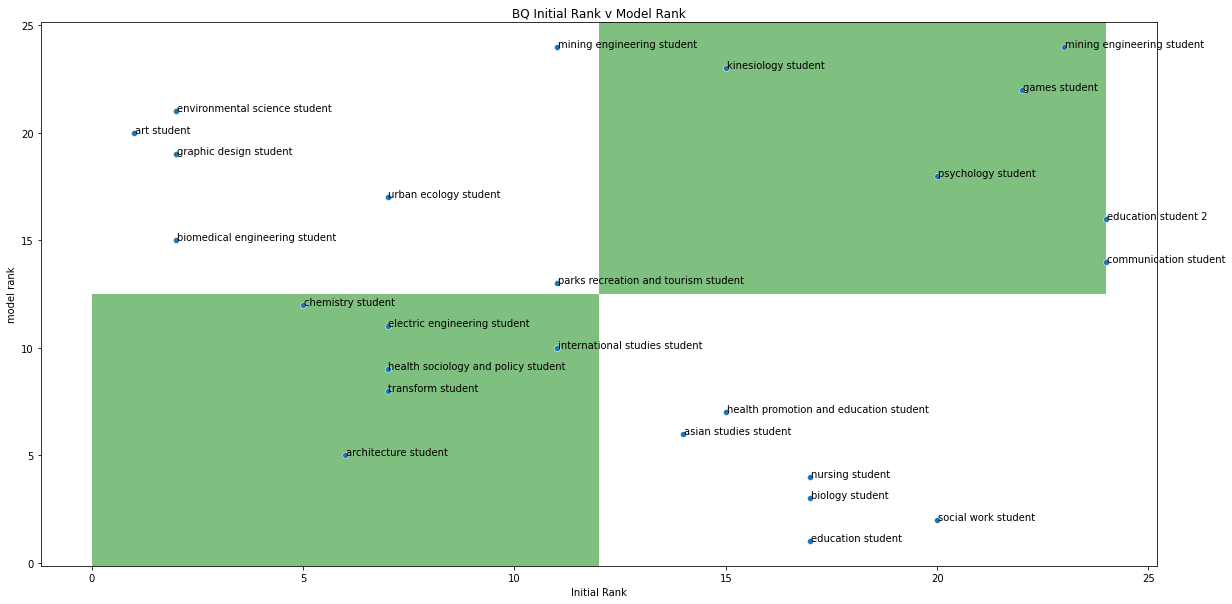

In [127]:
model_evaluations_hex(outliers_removed_mean)

In [128]:
model_bq.reset_index(drop=True, inplace=True)
model_bq

,name,model rank,Initial Rank
0,art student,20.0,1
1,environmental science student,21.0,2
2,graphic design student,19.0,2
3,biomedical engineering student,15.0,2
4,chemistry student,12.0,5
5,architecture student,5.0,6
6,transform student,8.0,7
7,health sociology and policy student,9.0,7
8,electric engineering student,11.0,7
9,urban ecology student,17.0,7


In [129]:
#all the results for each model in one table

new_row = pandas.Series({'name': 'hexangulation no outliers', 
                         'kendall': tau, 
                         "kendall p-value" : kendall_p_value,
                         'spearman': spearman, 
                         "spearman p-value": spearman_p_value,
                         'pearson':pearson,
                         'pearson p-value': pearson_p_value })

model_eval_results_df = append_row(model_eval_results_df, new_row)

model_eval_results_df

,name,kendall,kendall p-value,spearman,spearman p-value,pearson,pearson p-value
0,jaccard processed,-0.030994,0.832449,0.023580,0.910920,0.041479,0.843935
1,cosine no process all words,-0.182522,0.212816,-0.212604,0.307576,-0.212226,0.308458
2,cosine no process all words count,-0.079208,0.588744,-0.067260,0.749389,-0.067379,0.748961
3,cosine no process all words nltk stop words,-0.182522,0.212816,-0.212604,0.307576,-0.212226,0.308458
4,cosine no process pd words only,0.079208,0.588744,0.125629,0.549595,0.118178,0.573698
5,cosine processed all words,-0.079208,0.588744,-0.026286,0.900745,-0.020374,0.922993
6,cosine processed pd words only,-0.079208,0.588744,-0.142251,0.497578,-0.163062,0.436095
7,hexangulation,-0.113646,0.437912,-0.080016,0.703790,-0.075084,0.721312
8,hexangulation no outliers,-0.120534,0.410657,-0.086588,0.680671,-0.076967,0.714606


In [130]:
#adding formatting to the table

from functools import partial

def css_border(x,pos):
        return ["border-left: 1px solid black" if i in pos else "border: 0px" for i, col in enumerate(x)]
def display_df_with_delimiter(df,pos):
    return df.style.apply(partial(css_border,pos=pos), axis=1)

formated_model_eval_results = display_df_with_delimiter(model_eval_results_df,[1,3,5,7])

formated_model_eval_results

,name,kendall,kendall p-value,spearman,spearman p-value,pearson,pearson p-value
0,jaccard processed,-0.030994,0.832449,0.023580,0.910920,0.041479,0.843935
1,cosine no process all words,-0.182522,0.212816,-0.212604,0.307576,-0.212226,0.308458
2,cosine no process all words count,-0.079208,0.588744,-0.067260,0.749389,-0.067379,0.748961
3,cosine no process all words nltk stop words,-0.182522,0.212816,-0.212604,0.307576,-0.212226,0.308458
4,cosine no process pd words only,0.079208,0.588744,0.125629,0.549595,0.118178,0.573698
5,cosine processed all words,-0.079208,0.588744,-0.026286,0.900745,-0.020374,0.922993
6,cosine processed pd words only,-0.079208,0.588744,-0.142251,0.497578,-0.163062,0.436095
7,hexangulation,-0.113646,0.437912,-0.080016,0.703790,-0.075084,0.721312
8,hexangulation no outliers,-0.120534,0.410657,-0.086588,0.680671,-0.076967,0.714606


## Removing the top and bottom ranks from the polyangulation

In [131]:
# group by the 'group' column
grouped = eval_model_tri_all.groupby('name')

# apply a function to each group to drop the highest and lowest value
# unless there is a duplicate value and then keep only one
def drop_outliers(group):
    if len(group) == 1:
        return group
    else:
        group = group.sort_values('model rank')
        if group['model rank'].nunique() == 1:
            return group.iloc[[0]]
        else:
            return group.iloc[1:-1]

eval_model_poly_high_low_drop= grouped.apply(drop_outliers).reset_index(drop=True)
eval_model_poly_high_low_drop

,model rank,name,Initial Rank
0,4.0,architecture student,6
1,4.0,architecture student,6
2,5.0,architecture student,6
3,7.0,architecture student,6
4,7.0,architecture student,6
5,18.0,art student,1
6,18.0,art student,1
7,19.0,art student,1
8,20.0,art student,1
9,20.0,art student,1


In [132]:
poly_high_low_removed_mean = eval_model_poly_high_low_drop.groupby(['name'], as_index=False).agg(
                      {'model rank':['mean','std']})

poly_high_low_removed_mean.columns = ['name','mean','std']
poly_high_low_removed_mean = poly_high_low_removed_mean.sort_values(by=['std'], ascending = False)
poly_high_low_removed_mean['model rank'] = poly_high_low_removed_mean['mean'].rank(ascending = True)
poly_high_low_removed_mean = poly_high_low_removed_mean.sort_values(by=['model rank'], ascending = True)
poly_high_low_removed_mean.reset_index(drop=True, inplace=True)

poly_high_low_removed_mean

,name,mean,std,model rank
0,education student,1.600000,0.547723,1.0
1,social work student,2.200000,1.095445,2.0
2,biology student,4.000000,1.000000,3.0
3,nursing student,5.200000,0.836660,4.0
4,architecture student,5.400000,1.516575,5.0
5,health promotion and education student,6.600000,3.049590,6.0
6,asian studies student,7.600000,2.509980,7.0
7,health sociology and policy student,10.800000,5.019960,8.0
8,transform student,11.200000,0.836660,9.5
9,international studies student,11.200000,2.387467,9.5


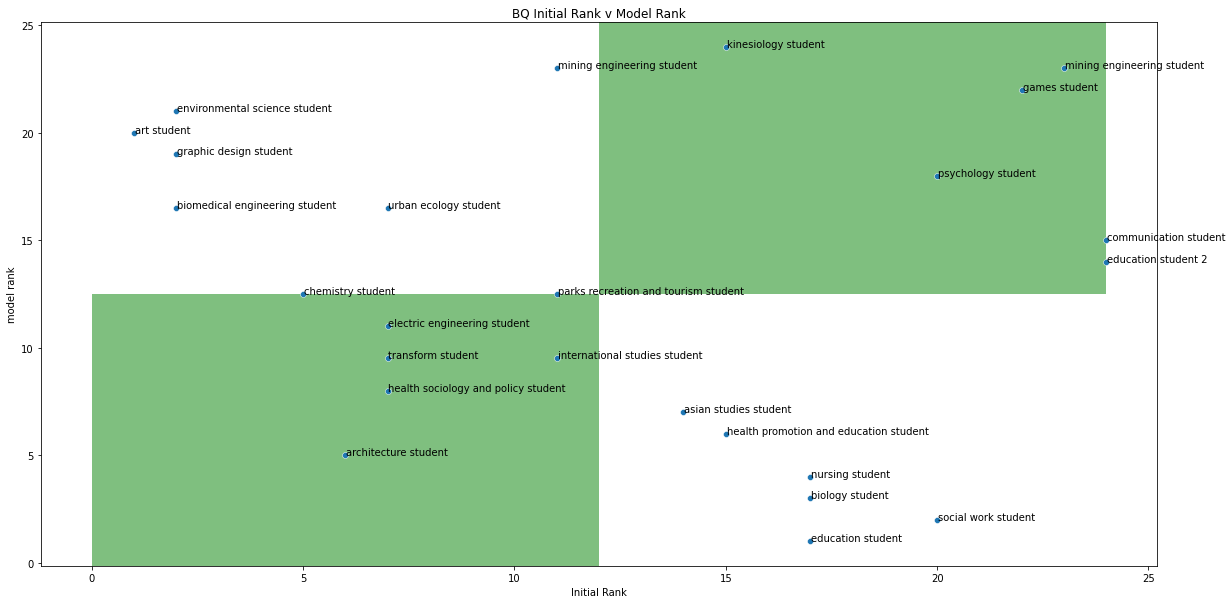

In [133]:
model_evaluations_hex(poly_high_low_removed_mean)

In [134]:
model_bq.reset_index(drop=True, inplace=True)
model_bq

,name,model rank,Initial Rank
0,art student,20.0,1
1,environmental science student,21.0,2
2,graphic design student,19.0,2
3,biomedical engineering student,16.5,2
4,chemistry student,12.5,5
5,architecture student,5.0,6
6,health sociology and policy student,8.0,7
7,transform student,9.5,7
8,electric engineering student,11.0,7
9,urban ecology student,16.5,7


In [135]:
#all the results for each model in one table

new_row = pandas.Series({'name': 'polyangulation high low drop', 
                         'kendall': tau, 
                         "kendall p-value" : kendall_p_value,
                         'spearman': spearman, 
                         "spearman p-value": spearman_p_value,
                         'pearson':pearson,
                         'pearson p-value': pearson_p_value })

model_eval_results_df = append_row(model_eval_results_df, new_row)

model_eval_results_df

,name,kendall,kendall p-value,spearman,spearman p-value,pearson,pearson p-value
0,jaccard processed,-0.030994,0.832449,0.023580,0.910920,0.041479,0.843935
1,cosine no process all words,-0.182522,0.212816,-0.212604,0.307576,-0.212226,0.308458
2,cosine no process all words count,-0.079208,0.588744,-0.067260,0.749389,-0.067379,0.748961
3,cosine no process all words nltk stop words,-0.182522,0.212816,-0.212604,0.307576,-0.212226,0.308458
4,cosine no process pd words only,0.079208,0.588744,0.125629,0.549595,0.118178,0.573698
5,cosine processed all words,-0.079208,0.588744,-0.026286,0.900745,-0.020374,0.922993
6,cosine processed pd words only,-0.079208,0.588744,-0.142251,0.497578,-0.163062,0.436095
7,hexangulation,-0.113646,0.437912,-0.080016,0.703790,-0.075084,0.721312
8,hexangulation no outliers,-0.120534,0.410657,-0.086588,0.680671,-0.076967,0.714606
9,polyangulation high low drop,-0.145371,0.323125,-0.113712,0.588361,-0.106356,0.612861


In [136]:
#adding formatting to the table

from functools import partial

def css_border(x,pos):
        return ["border-left: 1px solid black" if i in pos else "border: 0px" for i, col in enumerate(x)]
def display_df_with_delimiter(df,pos):
    return df.style.apply(partial(css_border,pos=pos), axis=1)

formated_model_eval_results = display_df_with_delimiter(model_eval_results_df,[1,3,5,7])

formated_model_eval_results

,name,kendall,kendall p-value,spearman,spearman p-value,pearson,pearson p-value
0,jaccard processed,-0.030994,0.832449,0.023580,0.910920,0.041479,0.843935
1,cosine no process all words,-0.182522,0.212816,-0.212604,0.307576,-0.212226,0.308458
2,cosine no process all words count,-0.079208,0.588744,-0.067260,0.749389,-0.067379,0.748961
3,cosine no process all words nltk stop words,-0.182522,0.212816,-0.212604,0.307576,-0.212226,0.308458
4,cosine no process pd words only,0.079208,0.588744,0.125629,0.549595,0.118178,0.573698
5,cosine processed all words,-0.079208,0.588744,-0.026286,0.900745,-0.020374,0.922993
6,cosine processed pd words only,-0.079208,0.588744,-0.142251,0.497578,-0.163062,0.436095
7,hexangulation,-0.113646,0.437912,-0.080016,0.703790,-0.075084,0.721312
8,hexangulation no outliers,-0.120534,0.410657,-0.086588,0.680671,-0.076967,0.714606
9,polyangulation high low drop,-0.145371,0.323125,-0.113712,0.588361,-0.106356,0.612861
